In [1]:
from pathlib import Path
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold, GroupKFold
from sklearn.linear_model import LinearRegression

import seaborn as sns
from matplotlib import pyplot as plt
import statsmodels.formula.api as smf
from pymer4.models import Lmer
from scipy import stats
import itertools
pd.set_option('display.max_columns', 500)
%matplotlib inline

In [2]:
def kfold_linear(data, model):
    kf = KFold(n_splits=8)
    fits = []
    reses = []
    for fix, (train_ind, test_ind) in enumerate(kf.split(data)):
        mdl = smf.ols(model, data.loc[train_ind])
        fitted = mdl.fit()
        res = data.loc[test_ind, ['SDAN'] + [mdl.endog_names]].copy()
        res[f'{mdl.endog_names}_predicted'] = fitted.predict(data.loc[test_ind])
        res['fold'] = fix
        reses.append(res)
        fits.append(fitted)
    reses = pd.concat(reses)
    return fits, reses

def kfold_lme(data, model, other_vars = None):
    gkf = GroupKFold(n_splits=8)
    fit_mdls = []
    reses = []
    for tix,(train_ind, test_ind) in enumerate(gkf.split(data, groups=data.SDAN)):
        mdl = Lmer(model, data.loc[train_ind])
        _ = mdl.fit()
        y_name = model.split("~")[0].strip()
        vars_to_copy = ['SDAN'] + [y_name]
        if other_vars is not None:
            vars_to_copy.extend(other_vars)
        res = data.loc[test_ind, vars_to_copy].copy()
        res[f'{y_name}_predicted'] = mdl.predict(data.loc[test_ind])
        res['fold'] = tix
        reses.append(res)
        fit_mdls.append(mdl)
    reses = pd.concat(reses)
    return fit_mdls, reses

def get_rsquared(var, df):
    var_pred = var + '_predicted'
    num = ((df[var] - df[var_pred])**2).sum()
    den = ((df[var] - df[var].mean())**2).sum()
    r_squared = 1 - (num / den)
    return r_squared

def get_95ci(var, df):
    means = []
    for inds in itertools.product(df.index, repeat=len(df.index)):
        vals = []
        for ix in inds:
            vals.append(df.loc[ix, var])
        means.append(np.mean(vals))
    lci, uci = np.percentile(means, [2.5, 97.5])
    return pd.Series({f'{var}_lci': lci, f'{var}_uci':uci})

def get_99ci(var, df):
    means = []
    for inds in itertools.product(df.index, repeat=len(df.index)):
        vals = []
        for ix in inds:
            vals.append(df.loc[ix, var])
        means.append(np.mean(vals))
    lci, uci = np.percentile(means, [0.5, 99.5])
    return pd.Series({f'{var}_lci': lci, f'{var}_uci':uci})

def get_999ci(var, df):
    means = []
    bootstrap_folds = list(itertools.product(df.index, repeat=len(df.index)))
    bootstrap_folds = set([tuple(sorted(x)) for x in bootstrap_folds])
    for inds in bootstrap_folds:
        vals = []
        for ix in inds:
            vals.append(df.loc[ix, var])
        means.append(np.mean(vals))
    lci, uci = np.percentile(means, [0.05, 99.95])
    return pd.Series({f'{var}_lci': lci, f'{var}_uci':uci})

# def corr_plot(corr, for_cors, alpha=0.05, bonferoni_denomenator=None):
#     mask = np.tril(np.ones_like(corr, dtype=bool))
#     annots = corr.copy()
#     ps = corr.copy()
#     if bonferoni_denomenator is None:
#         bonferoni_alpha = alpha/mask.sum()
#     else:
#         bonferoni_alpha = alpha/bonferoni_denomenator
#     for ix,row in corr.iterrows():
#         for name in row.index:
#             r, p = stats.pearsonr(for_cors[ix], for_cors[name])
#             ps.loc[ix, name] = p
#             annot = f"${corr.loc[ix, name]:0.2g}"
#             if p < bonferoni_alpha:
#                 annot += "^*$"
#             else:
#                 annot += "$"
#             annots.loc[ix, name] = annot
    
#     fig, ax = plt.subplots(figsize=(11, 9), dpi=250)
#     cmap = sns.diverging_palette(230, 20, as_cmap=True)
#     sns.heatmap(corr.iloc[:-1, 1:], mask=mask[:-1, 1:], cmap=cmap, vmax=1, vmin=-1, center=0,
#                 square=True, linewidths=.5, cbar_kws={"shrink": .5},
#                 annot=annots.iloc[:-1, 1:], fmt="")
#     return fig,ax

def corr_plot(corr, for_cors, alpha=0.05, bonferoni_denomenator=None, cluster_var=None):
    mask = np.tril(np.ones_like(corr, dtype=bool))
    annots = corr.copy()
    ps = corr.copy()
    if bonferoni_denomenator is None:
        bonferoni_alpha = alpha/mask.sum()
    else:
        bonferoni_alpha = alpha/bonferoni_denomenator
    for ix,row in corr.iterrows():
        for name in row.index:
            if cluster_var is None:
                r, p = stats.pearsonr(for_cors[ix], for_cors[name])
            elif ix == name:
                p = np.nan
            else:
                zs = for_cors.loc[for_cors['level_1'] == ix, name]
                zs = zs[pd.notnull(zs)]
                t, p = stats.ttest_1samp(zs, 0)
                mean = np.tanh(for_cors.loc[for_cors['level_1'] == ix, name].mean())
                se = np.tanh(for_cors.loc[for_cors['level_1'] == ix, name].std() / np.sqrt(for_cors[cluster_var].nunique()))
                dof = for_cors[cluster_var].nunique() - 1
            ps.loc[ix, name] = p
            annot = f"${corr.loc[ix, name]:0.2g}"
    #         if cluster_var is not None:
    #             se = np.tanh(for_cors.loc[for_cors['level_1'] == ix, name].std() / np.sqrt(for_cors[cluster_var].nunique()))
    #             annot += f"\pm{se:0.2g}"
            if p < bonferoni_alpha:
                if cluster_var is None:
                    if ix != name:
                        print(ix, name, r, len(for_cors[ix]), p )
                else:
                    print(ix, name, mean, se, t, dof, p)
                annot += "^*$"
            else:
                annot += "$"
            annots.loc[ix, name] = annot
    corr.index.name = None
    fig, ax = plt.subplots(figsize=(11, 9), dpi=250)
    cmap = sns.diverging_palette(230, 20, as_cmap=True)
    sns.heatmap(corr.iloc[:-1, 1:], mask=mask[:-1, 1:], cmap=cmap, vmax=1, vmin=-1, center=0,
                square=True, linewidths=.5, cbar_kws={"shrink": .5},
                annot=annots.iloc[:-1, 1:], fmt="")
    return fig,ax

# Deal with weekly predictions first

### data changes done in excel
- delete initials column
- delete duplicated row for 23952

In [3]:
wdat = pd.read_csv('../data/WeeksofDepression5.24.2021reduced.csv', index_col=0).reset_index(drop=True)
wdat = wdat.rename(columns={'AgeatV1': 'Age_at_visit',
                            'v1MFQScore': 'BaselineMFQScore'})

In [4]:
wdat.TimeBetweenv1v4visits.mean(), wdat.TimeBetweenv1v4visits.std() 

(372.9347826086956, 25.29726751861287)

In [5]:
pure_dat = wdat.copy()
wdat = wdat.loc[(wdat.drop(['v4MFQDate', 'v4MFQScore'], axis=1).isnull().sum(1)==0)].copy()

In [6]:
# make sure each subject is only in there once
assert len(wdat.groupby('SDAN')[['Participant_Type2']].count().query('Participant_Type2 > 1')) == 0
# make sure there are 72 people with no nulls
assert (wdat.drop(['v4MFQDate', 'v4MFQScore'], axis=1).isnull().sum(1)==0).sum() == 72
# make sure there are only MDDs in this group
assert wdat.Participant_Type2.unique()[0] == 'MDD'
# make sure there are only male and femal in the sex column
assert set(wdat.SEX.unique()) == {'FEMALE', 'MALE'}

In [7]:
wdat.describe()

,SDAN,BaselineMFQScore,v4MFQScore,Age_at_visit,Inpatient,BaselineAntiDep,BaselineOtherMeds,FUAntiDep,FUOtherMeds,dep_immed,s_case__neg_tot,c_ksadsdx_epset_annual_weeks_mdd,TimeBetweenv1v4visits
count,72.000000,72.000000,67.000000,72.000000,72.000000,72.000000,72.000000,72.000000,72.000000,72.000000,72.000000,72.000000,72.000000
mean,23792.680556,11.759678,9.074673,15.828333,0.263889,0.472222,0.319444,0.583333,0.305556,0.708333,4.486111,21.486111,372.666667
std,402.477847,6.926224,6.415539,1.341253,0.443833,0.502731,0.469533,0.496466,0.463875,0.457719,3.918152,18.288758,25.196691
min,22228.000000,0.000000,0.000000,11.830000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,313.000000
25%,23666.000000,6.000000,4.000000,14.940000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,3.750000,358.000000
50%,23827.500000,11.500000,8.000000,16.020000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,4.000000,20.000000,369.000000
75%,24064.250000,16.000000,13.000000,16.750000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,6.000000,36.750000,384.500000
max,24264.000000,25.005000,23.000000,17.940000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,22.000000,57.000000,448.000000


In [8]:
pure_dat.head()

,SDAN,Participant_Type2,v1Date,v1MFQDate,BaselineMFQScore,v4Date,v4MFQDate,v4MFQScore,SEX,Age_at_visit,Inpatient,postpandemic,BaselineAntiDep,BaselineOtherMeds,FUAntiDep,FUOtherMeds,dep_immed,s_case__neg_tot,c_ksadsdx_epset_annual_weeks_mdd,TimeBetweenv1v4visits
0,24088,MDD,2019-04-29,2019-04-29,13.0000,2020-07-20,2020-07-20,7.0,FEMALE,14.79,1,True,1,1,1.0,0.0,1,2.0,52,448
1,22699,MDD,2019-02-05,2019-02-05,2.0000,2020-01-13,2020-01-13,6.0,FEMALE,16.67,0,False,0,0,0.0,0.0,1,0.0,30,342
2,23660,MDD,2018-01-15,2018-01-16,24.0000,2019-02-26,2019-02-26,20.0,FEMALE,16.80,1,False,1,1,0.0,0.0,1,1.0,52,407
3,23951,MDD,2018-09-25,2018-09-25,9.1143,2019-10-11,2019-10-11,13.0,FEMALE,13.57,1,False,1,1,1.0,0.0,0,3.0,16,381
4,23810,MDD,2018-06-04,2018-06-04,11.0000,2019-07-17,NaN,NaN,FEMALE,14.60,0,False,0,0,0.0,0.0,1,5.0,40,408


In [9]:
models = {'Null':'c_ksadsdx_epset_annual_weeks_mdd ~ BaselineAntiDep + BaselineOtherMeds + FUAntiDep + FUOtherMeds + Inpatient + SEX + Age_at_visit + postpandemic',
          'FH':'c_ksadsdx_epset_annual_weeks_mdd ~ dep_immed + BaselineAntiDep + BaselineOtherMeds + FUAntiDep + FUOtherMeds + Inpatient + SEX + Age_at_visit + postpandemic',
          'MFQ':'c_ksadsdx_epset_annual_weeks_mdd ~ BaselineMFQScore + BaselineAntiDep + BaselineOtherMeds + FUAntiDep + FUOtherMeds + Inpatient + SEX + Age_at_visit + postpandemic',
          'MFQ+FH':'c_ksadsdx_epset_annual_weeks_mdd ~ BaselineMFQScore + dep_immed + BaselineAntiDep + BaselineOtherMeds + FUAntiDep + FUOtherMeds + Inpatient + SEX + Age_at_visit + postpandemic',
          'MFQ+FH+CASE':'c_ksadsdx_epset_annual_weeks_mdd ~ BaselineMFQScore + (dep_immed*s_case__neg_tot) + BaselineAntiDep + BaselineOtherMeds + FUAntiDep + FUOtherMeds + Inpatient + SEX + Age_at_visit + postpandemic',
          'BSL_Null': 'c_ksadsdx_epset_annual_weeks_mdd ~ BaselineAntiDep + BaselineOtherMeds + SEX + Age_at_visit + postpandemic',
          'BSL_FH': 'c_ksadsdx_epset_annual_weeks_mdd ~ dep_immed + BaselineAntiDep + BaselineOtherMeds + SEX + Age_at_visit + postpandemic',
          'BSL_MFQ': 'c_ksadsdx_epset_annual_weeks_mdd ~ BaselineMFQScore + BaselineAntiDep + BaselineOtherMeds + SEX + Age_at_visit + postpandemic',
          'BSL_MFQ+FH': 'c_ksadsdx_epset_annual_weeks_mdd ~ dep_immed + BaselineMFQScore + BaselineAntiDep + BaselineOtherMeds + SEX + Age_at_visit + postpandemic',
          }
model_names = list(models.keys())

Weeks of Depression Baseline MFQ 0.40356167313997227 72 0.0004394775702647363
Weeks of Depression SLEs 0.3989965967414398 72 0.0005171398809868559
Baseline MFQ Weeks of Depression 0.40356167313997227 72 0.0004394775702647363
Baseline MFQ SLEs 0.402364470305511 72 0.0004587414345532653
SLEs Weeks of Depression 0.3989965967414398 72 0.0005171398809868559
SLEs Baseline MFQ 0.402364470305511 72 0.0004587414345532653
Antidepressants at Baseline Other Meds at Baseline 0.48562876275657796 72 1.532197872734502e-05
Antidepressants at Baseline Antidepressants at FU 0.4608512785365715 72 4.6259565292035e-05
Antidepressants at Baseline Other Meds at FU 0.4596771955627793 72 4.864464453455945e-05
Other Meds at Baseline Antidepressants at Baseline 0.48562876275657796 72 1.532197872734502e-05
Other Meds at Baseline Other Meds at FU 0.5801953147091541 72 9.217487546134408e-08
Antidepressants at FU Antidepressants at Baseline 0.4608512785365715 72 4.6259565292035e-05
Antidepressants at FU Other Meds at

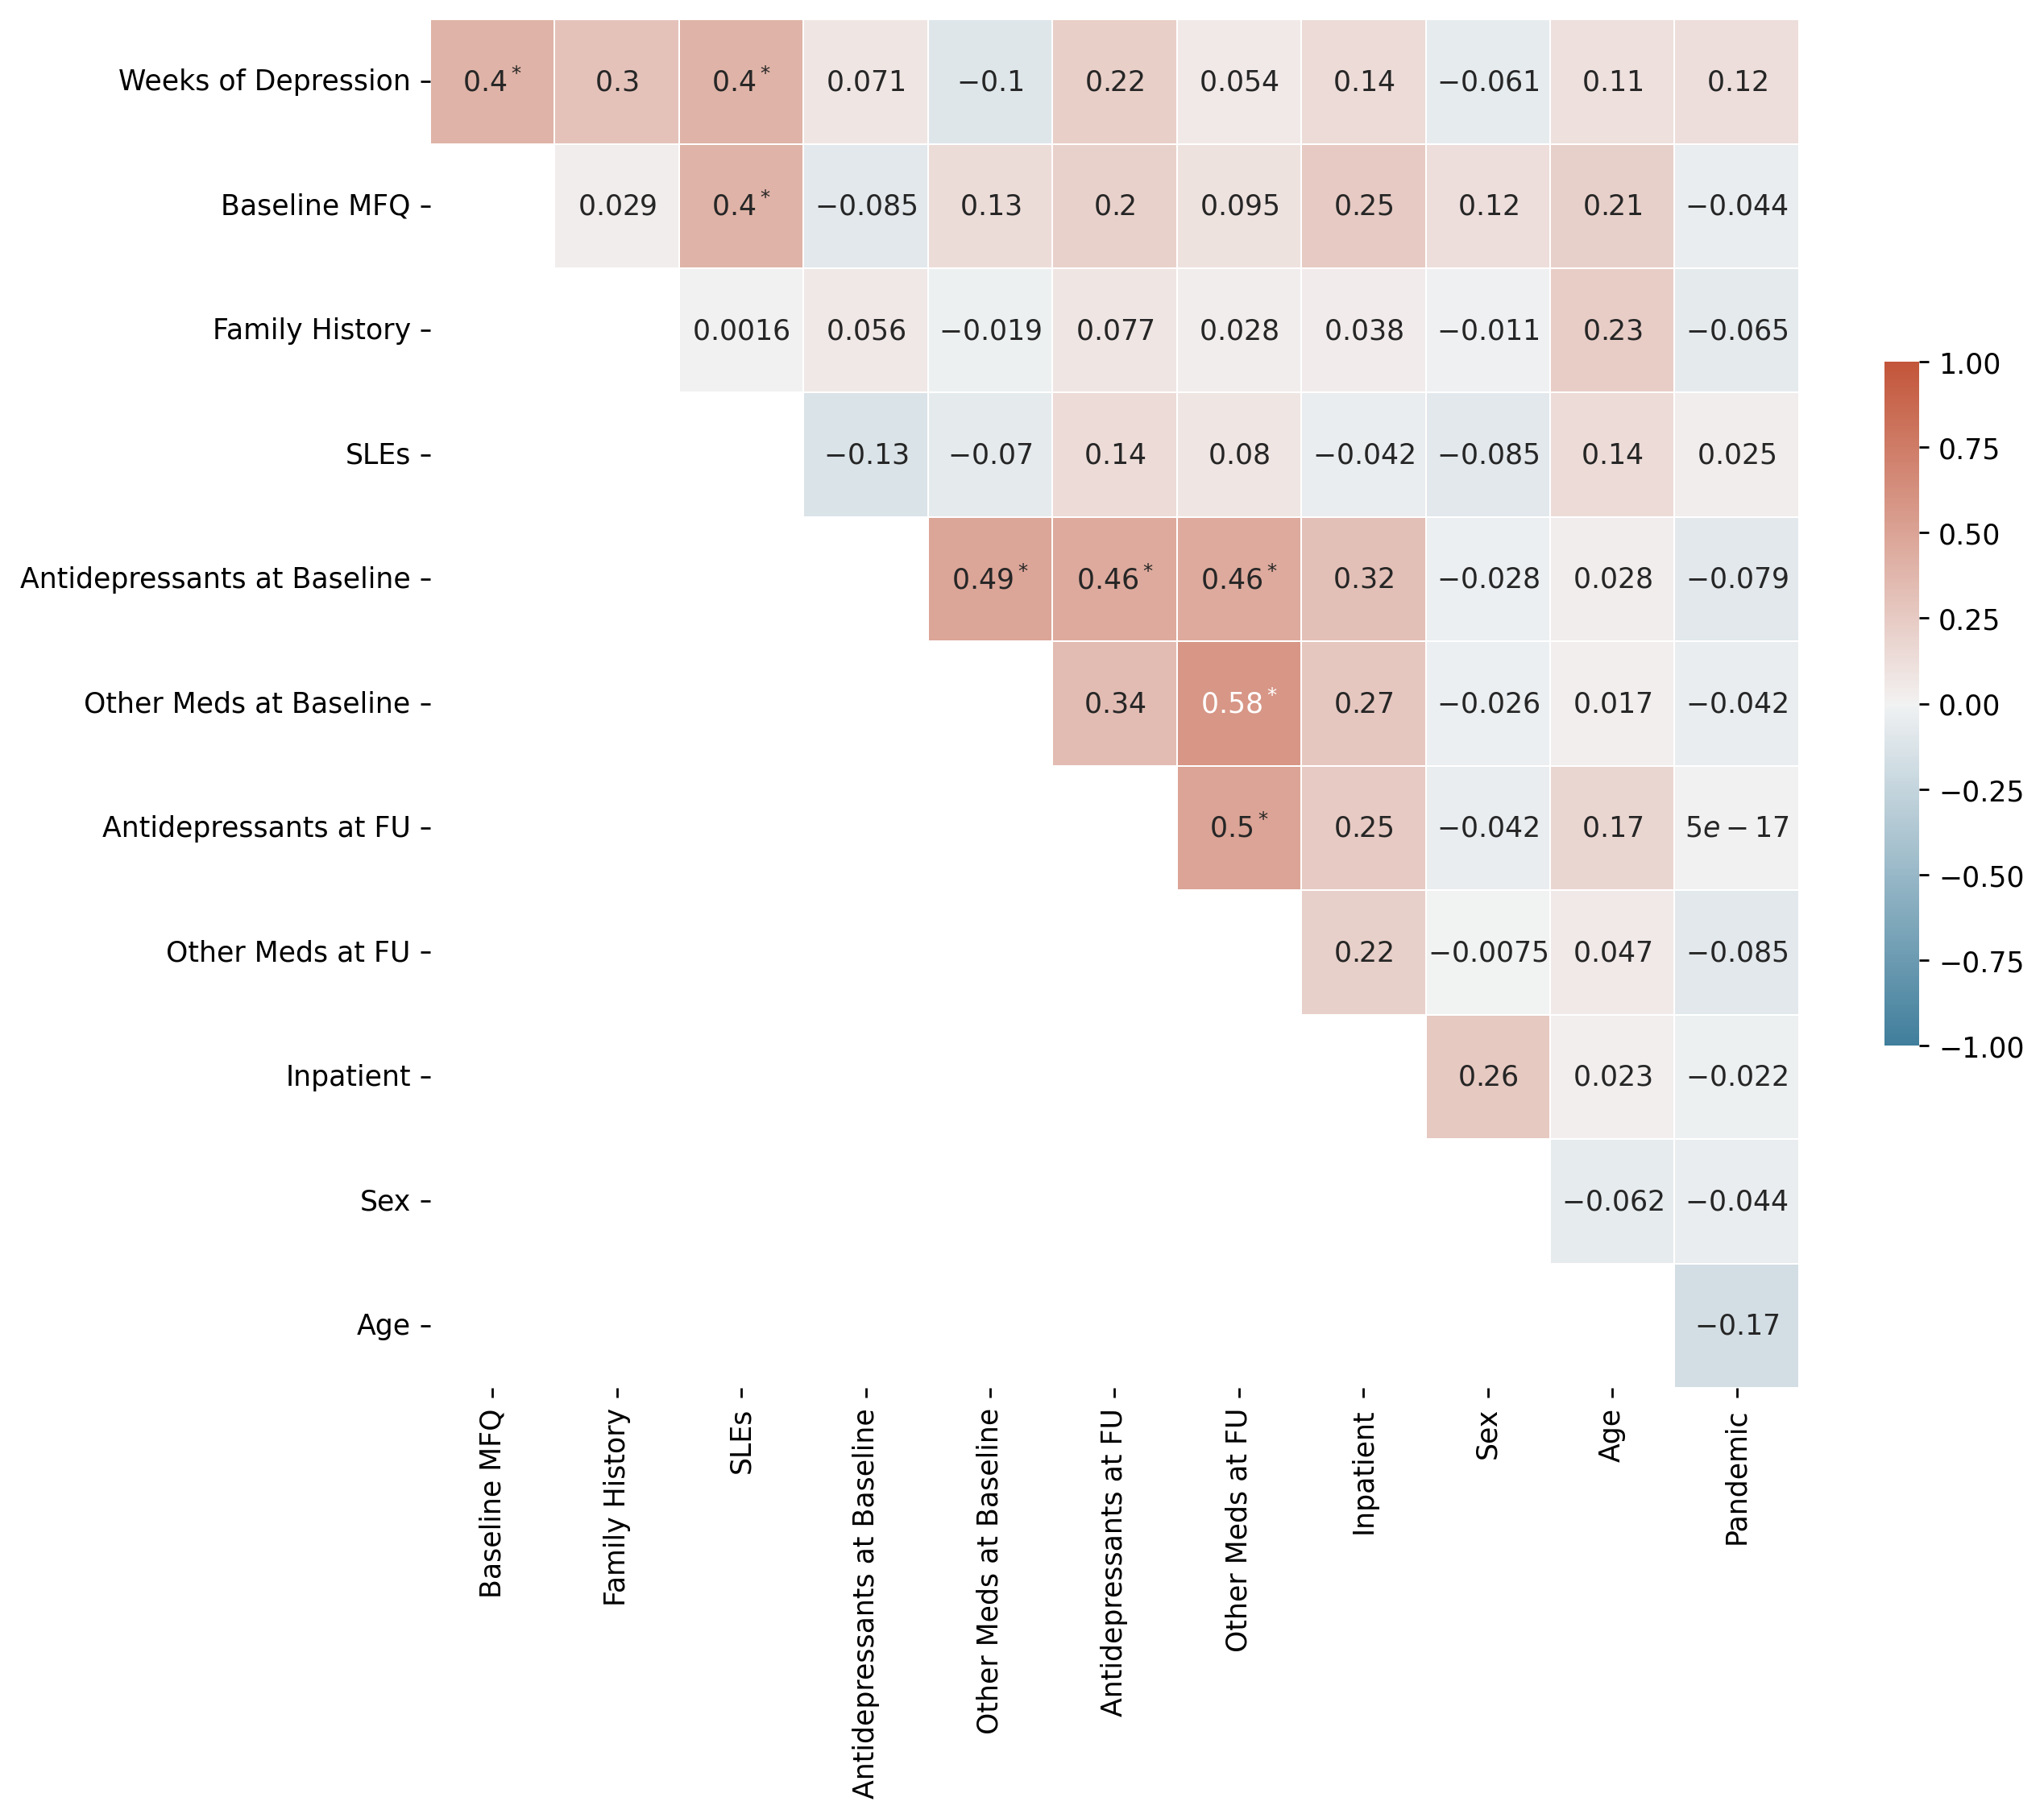

In [10]:
all_terms = {
    "c_ksadsdx_epset_annual_weeks_mdd": "Weeks of Depression",
    "BaselineMFQScore": "Baseline MFQ",
"dep_immed": "Family History",
"s_case__neg_tot": "SLEs",
"BaselineAntiDep": "Antidepressants at Baseline",
"BaselineOtherMeds": "Other Meds at Baseline",
"FUAntiDep": "Antidepressants at FU",
"FUOtherMeds":"Other Meds at FU",
"Inpatient":"Inpatient",
"SEX":"Sex",
"Age_at_visit": "Age",
"postpandemic": "Pandemic"}
for_cors = wdat.loc[:, all_terms.keys()].copy()
for_cors['SEX'] = (for_cors.SEX == "MALE").astype(int)
for_cors = for_cors.rename(columns=all_terms)
corr = for_cors.corr()
mask = np.tril(np.ones_like(corr, dtype=bool))
fig,ax = corr_plot(corr, for_cors)
fig.set_facecolor("white")

In [11]:
var = 'c_ksadsdx_epset_annual_weeks_mdd'
var_pred = var + '_predicted'

In [12]:
reses = []
for mix, model in models.items():
    if "BSL" in mix:
        
        data = pure_dat.copy().reset_index(drop=True)
    else:
        data = wdat.copy().reset_index(drop=True)
    ffs, rrs = kfold_linear(data, model)
    rrs['model'] = mix
    reses.append(rrs)
reses = pd.concat(reses)
reses['squared_error'] = (reses[var] - reses[var_pred]) ** 2
reses['abs_error'] = np.abs((reses[var] - reses[var_pred]))
reses['error'] = (reses[var_pred] - reses[var])
mf_agg = reses.groupby(['model', 'fold']).apply(lambda x: get_rsquared(var, x)).reset_index(name='r-squared')
mf_agg['rmse'] = np.sqrt(reses.groupby(['model', 'fold']).squared_error.mean()).reset_index(name='rmse').loc[:, ['rmse']]
mf_agg['mae'] = reses.groupby(['model', 'fold']).abs_error.mean().reset_index(name='rmse').loc[:, ['rmse']]
to_plot = reses.copy()
to_plot = to_plot.rename(
    columns={
        'c_ksadsdx_epset_annual_weeks_mdd':'Actual Weeks of Depression',
        'c_ksadsdx_epset_annual_weeks_mdd_predicted':'Predicted Weeks of Depression',
        'model': 'Model',
        'fold': 'Fold'
    })


<AxesSubplot:xlabel='error', ylabel='model'>

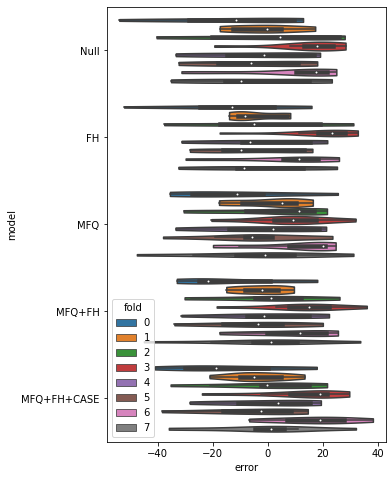

In [13]:
fig,ax = plt.subplots(1, figsize=(5,8))
tmp_plot = reses.loc[~reses.model.str.contains("BSL")].copy()
tmp_plot['fold'] = tmp_plot.fold.astype(str)
sns.violinplot(data=tmp_plot, x="error", y="model", hue="fold", cut=0, ax=ax)

<AxesSubplot:xlabel='abs_error', ylabel='model'>

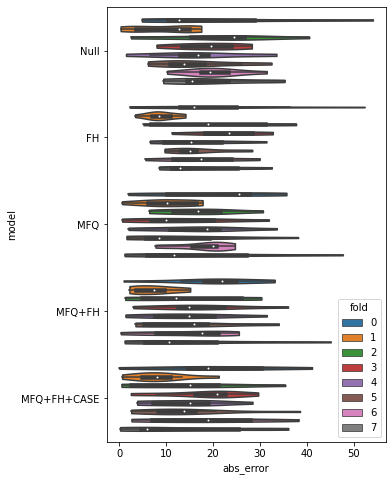

In [14]:
fig,ax = plt.subplots(1, figsize=(5,8))
tmp_plot = reses.loc[~reses.model.str.contains("BSL")].copy()
tmp_plot['fold'] = tmp_plot.fold.astype(str)
sns.violinplot(data=tmp_plot, x="abs_error", y="model", hue="fold", cut=0, ax=ax)

<AxesSubplot:xlabel='squared_error', ylabel='model'>

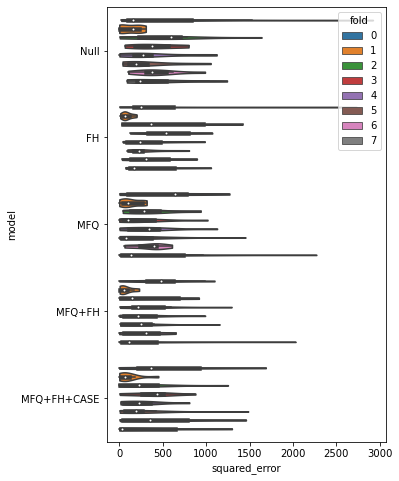

In [15]:
fig,ax = plt.subplots(1, figsize=(5,8))
tmp_plot = reses.loc[~reses.model.str.contains("BSL")].copy()
tmp_plot['fold'] = tmp_plot.fold.astype(str)
sns.violinplot(data=tmp_plot, x="squared_error", y="model", hue="fold", cut=0, ax=ax)

In [16]:
# Test the R-squared function
test = reses.copy()
test[var_pred] = test[var]
assert (test.groupby(['model', 'fold']).apply(lambda x: get_rsquared(var, x)) == 1).all()

test[var_pred] = test.groupby(['model', 'fold'])[[var]].transform('mean')
assert (test.groupby(['model', 'fold']).apply(lambda x: get_rsquared(var, x)) == 0).all()


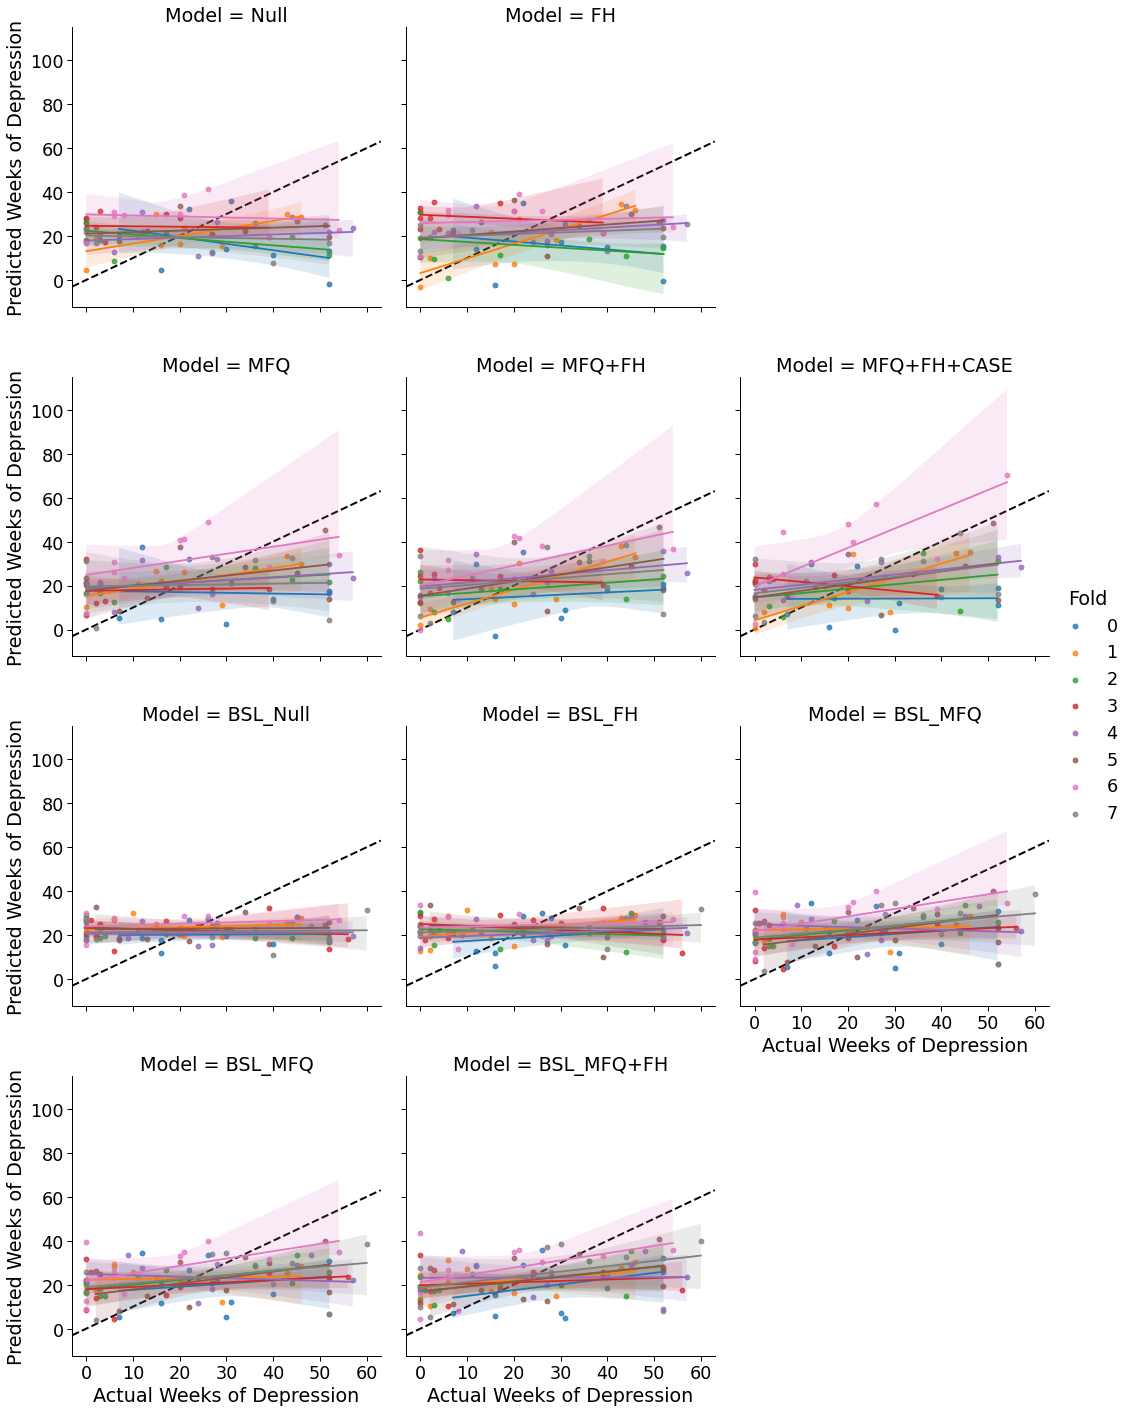

In [17]:
paper_rc = {'axes.facecolor':'white',
            'figure.facecolor':'white',
            'dpi': 250}
with sns.plotting_context("paper", font_scale=2, rc=paper_rc):
    g = sns.lmplot(x='Actual Weeks of Depression', 
               y='Predicted Weeks of Depression',
               data=to_plot,
               col='Model',
               col_wrap=3,
               col_order=['Null', 'FH', 'MFQ', 'MFQ', 'MFQ+FH', 'MFQ+FH+CASE', 'BSL_Null', 'BSL_FH', 'BSL_MFQ', 'BSL_MFQ', 'BSL_MFQ+FH'],
               hue='Fold',
               n_boot=10000)
    for ax in g.axes:
        ymin, ymax = ax.get_ylim()
        xmin, xmax = ax.get_xlim()
        ax.plot((xmin, xmax), (xmin, xmax),
                linestyle='dashed',
                color='black',
                linewidth=2,
                zorder=-1000)
        ax.set_ylim((ymin, ymax))
        ax.set_xlim((xmin, xmax))
    g.axes[2].set_visible(False)
    g.fig.set_facecolor("white")

<AxesSubplot:xlabel='squared_error', ylabel='Count'>

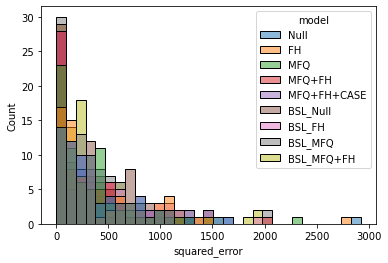

In [18]:
sns.histplot(data=reses.loc[~reses.model.str.contains("pure")].reset_index(drop=True), x="squared_error", hue="model")

<AxesSubplot:xlabel='abs_error', ylabel='Count'>

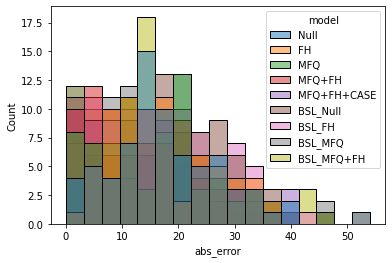

In [19]:
sns.histplot(data=reses.loc[~reses.model.str.contains("pure")].reset_index(drop=True), x="abs_error", hue="model")

Squared error is pretty far normal, not going to use an ANOVA

In [20]:
reses.groupby('model').squared_error.describe()

,count,mean,std,min,25%,50%,75%,max
model,,,,,,,,
BSL_FH,92.0,370.725615,383.382150,0.037712,65.997817,234.404654,554.550980,1939.269243
BSL_MFQ,92.0,334.019141,400.701160,0.029147,60.747512,205.990957,469.879766,2044.320341
BSL_MFQ+FH,92.0,321.860017,411.861102,0.005849,47.996372,202.317539,396.213565,1915.881235
BSL_Null,92.0,379.944508,379.120373,0.069026,62.984579,288.298016,589.974464,1480.123899
FH,72.0,404.860019,452.768287,5.063685,105.640016,243.649877,607.298882,2732.591700
MFQ,72.0,349.507827,409.621905,0.351236,61.699928,253.170572,451.454030,2269.643014
MFQ+FH,72.0,322.417943,387.397948,0.113925,28.955703,195.571437,477.874820,2030.606484
MFQ+FH+CASE,72.0,348.426367,409.782388,0.000024,37.884426,220.895382,451.537083,1687.228887
Null,72.0,423.781872,472.476714,0.086351,129.223183,287.443081,573.772396,2920.850352


In [21]:
pw_res_path = Path('../data/weeks_pairwise_res.csv')
if not pw_res_path.exists():
    df = mf_agg.copy()
    metrics = ['rmse', 'mae']
    res = []
    folds = df.fold.unique()
    bootstrap_folds = list(itertools.product(folds, repeat=len(folds)))
    bootstrap_folds = set([tuple(sorted(x)) for x in bootstrap_folds])
    for iix, inds in enumerate(bootstrap_folds):
        for bsfi, ix in enumerate(inds):
            for metric in metrics:
                row={}
                row['bsi'] = iix
                row['bsfold'] = bsfi
                row['metric'] = metric
                for model in model_names:
                    row[f'{model}'] = df.loc[(df.model == model) & (df.fold == ix), metric].values[0]
                res.append(row)
    pairwise_res = pd.DataFrame(res)
    pairwise_res.to_csv(pw_res_path, index=None)
else:
    pairwise_res = pd.read_csv(pw_res_path)

In [22]:
pairwise_res.query('metric == "rmse"').head(10)

,bsi,bsfold,metric,Null,FH,MFQ,MFQ+FH,MFQ+FH+CASE,BSL_Null,BSL_FH,BSL_MFQ,BSL_MFQ+FH
0,0,0,rmse,23.699958,24.055340,18.269027,18.397458,17.904348,22.332656,22.433547,16.833270,16.979731
2,0,1,rmse,20.406772,24.264523,16.262530,19.441708,19.841677,21.740161,22.676519,19.112070,19.669553
4,0,2,rmse,19.486305,18.068547,18.651008,16.938965,16.044331,21.055076,19.729630,22.946477,21.676593
6,0,3,rmse,18.114360,17.469434,17.712506,16.696012,17.521390,16.799470,17.740257,15.061669,15.332986
8,0,4,rmse,18.114360,17.469434,17.712506,16.696012,17.521390,16.799470,17.740257,15.061669,15.332986
10,0,5,rmse,20.946682,18.894475,18.777810,16.912338,21.856032,18.515761,18.645500,17.916338,18.442908
12,0,6,rmse,20.946682,18.894475,18.777810,16.912338,21.856032,18.515761,18.645500,17.916338,18.442908
14,0,7,rmse,20.946682,18.894475,18.777810,16.912338,21.856032,18.515761,18.645500,17.916338,18.442908
16,1,0,rmse,25.889864,25.028664,23.298608,22.408417,23.841656,16.296950,16.092576,17.037682,16.570708
18,1,1,rmse,20.406772,24.264523,16.262530,19.441708,19.841677,21.740161,22.676519,19.112070,19.669553


In [23]:
diffs_of_interest = [
     ('Null', 'FH'),
     ('Null', 'MFQ'),
     ('Null', 'MFQ+FH'),
     ('Null', 'MFQ+FH+CASE'),
     ('MFQ', 'MFQ+FH'),
     ('MFQ', 'MFQ+FH+CASE'),
     ('MFQ+FH', 'MFQ+FH+CASE'),
     ('BSL_Null', 'BSL_FH'),
     ('BSL_Null', 'BSL_MFQ'),
     ('BSL_Null', 'BSL_MFQ+FH'),
     ('BSL_MFQ', 'BSL_MFQ+FH'),
]
for mp in diffs_of_interest:
    print(f'{mp[0]} - {mp[1]}')

Null - FH
Null - MFQ
Null - MFQ+FH
Null - MFQ+FH+CASE
MFQ - MFQ+FH
MFQ - MFQ+FH+CASE
MFQ+FH - MFQ+FH+CASE
BSL_Null - BSL_FH
BSL_Null - BSL_MFQ
BSL_Null - BSL_MFQ+FH
BSL_MFQ - BSL_MFQ+FH


In [24]:
len(diffs_of_interest), 0.05 / len(diffs_of_interest)/2

(11, 0.002272727272727273)

In [25]:
for mp in diffs_of_interest:
    pairwise_res[f'{mp[0]} - {mp[1]}'] = pairwise_res[mp[0]] - pairwise_res[mp[1]]

In [26]:
pairwise_res.bsi.nunique()

6435

In [27]:

doi_names = [f'{dda} - {ddb}' for dda, ddb in diffs_of_interest]
to_plot = pairwise_res.query('metric == "rmse"').groupby('bsi').mean().loc[:, doi_names[::-1]]
to_plot_cis = to_plot.quantile([0.0005, 0.9995]).T
to_plot_means = to_plot.mean().T
to_plot_cis['meanval'] = to_plot_means
to_plot_cis = to_plot_cis.reset_index()
to_plot_cis[0.0005] = to_plot_cis.meanval - to_plot_cis[0.0005]
to_plot_cis[0.9995] = to_plot_cis[0.9995] - to_plot_cis.meanval

In [28]:
to_plot_mae = pairwise_res.query('metric == "mae"').groupby('bsi').mean().loc[:, doi_names[::-1]]
to_plot_mae_cis = to_plot_mae.quantile([0.0005, 0.9995]).T
to_plot_mae_means = to_plot_mae.mean().T
to_plot_mae_cis['meanval'] = to_plot_mae_means
to_plot_mae_cis = to_plot_mae_cis.reset_index()
to_plot_mae_cis[0.0005] = to_plot_mae_cis.meanval - to_plot_mae_cis[0.0005]
to_plot_mae_cis[0.9995] = to_plot_mae_cis[0.9995] - to_plot_mae_cis.meanval

In [29]:
to_plot.to_csv('../data/method_compare/weeks_rmse_linear.csv', index=None)
to_plot_mae.to_csv('../data/method_compare/weeks_mae_linear.csv', index=None)

In [30]:
m_agg = mf_agg.groupby('model')[['rmse']].mean()
rmse_cis = mf_agg.groupby('model').apply(lambda x: get_999ci('rmse', x))
mae_agg = mf_agg.groupby('model')[['mae']].mean()
mae_cis = mf_agg.groupby('model').apply(lambda x: get_999ci('mae', x))
mr2_agg = mf_agg.groupby('model')[['r-squared']].mean()
r2_cis = mf_agg.groupby('model').apply(lambda x: get_999ci('r-squared', x))
pd.concat([m_agg,
           rmse_cis.loc[:, ['rmse_lci', 'rmse_uci']],
           mr2_agg.loc[:, ['r-squared']],
           r2_cis.loc[:, ['r-squared_lci', 'r-squared_uci']],
           mae_agg.loc[:, ['mae']],
           mae_cis.loc[:, ['mae_lci', 'mae_uci']]
          ], axis=1)

,rmse,rmse_lci,rmse_uci,r-squared,r-squared_lci,r-squared_uci,mae,mae_lci,mae_uci
model,,,,,,,,,
BSL_FH,19.072269,15.299624,22.578814,-0.169969,-0.330983,0.031306,16.445910,12.535823,20.398155
BSL_MFQ,18.171877,15.332504,22.293876,-0.084438,-0.454324,0.259347,15.350926,11.873212,19.293572
BSL_MFQ+FH,17.850281,15.217681,21.251214,-0.041461,-0.360706,0.247481,14.798369,12.645545,18.043518
BSL_Null,19.343934,16.360576,22.182021,-0.199249,-0.344645,-0.115730,16.597938,12.252119,20.609121
FH,19.544594,10.581677,24.831955,-0.528737,-2.409084,0.528804,17.548115,9.934266,22.614310
MFQ,18.393488,12.583255,22.944193,-0.233275,-1.119219,0.341257,15.702121,11.113516,19.853050
MFQ+FH,17.530090,9.662711,21.998042,-0.180951,-1.251702,0.602072,14.709741,8.288117,19.749236
MFQ+FH+CASE,18.284602,11.440856,23.312778,-0.302036,-1.420874,0.462339,15.271073,9.500358,20.033177
Null,20.200983,12.716562,25.322472,-0.530710,-1.707721,0.321670,17.948617,10.882891,20.803678


In [31]:
# m_agg = mf_agg.groupby('model')[['rmse']].mean()
# rmse_cis = mf_agg.groupby('model').apply(lambda x: get_999ci('rmse', x))
# mr2_agg = mf_agg.groupby('model')[['r-squared']].mean()
# r2_cis = mf_agg.groupby('model').apply(lambda x: get_999ci('r-squared', x))
# pd.concat([m_agg,
#            rmse_cis.loc[:, ['rmse_lci', 'rmse_uci']],
#            mr2_agg.loc[:, ['r-squared']],
#            r2_cis.loc[:, ['r-squared_lci', 'r-squared_uci']]
#           ], axis=1)

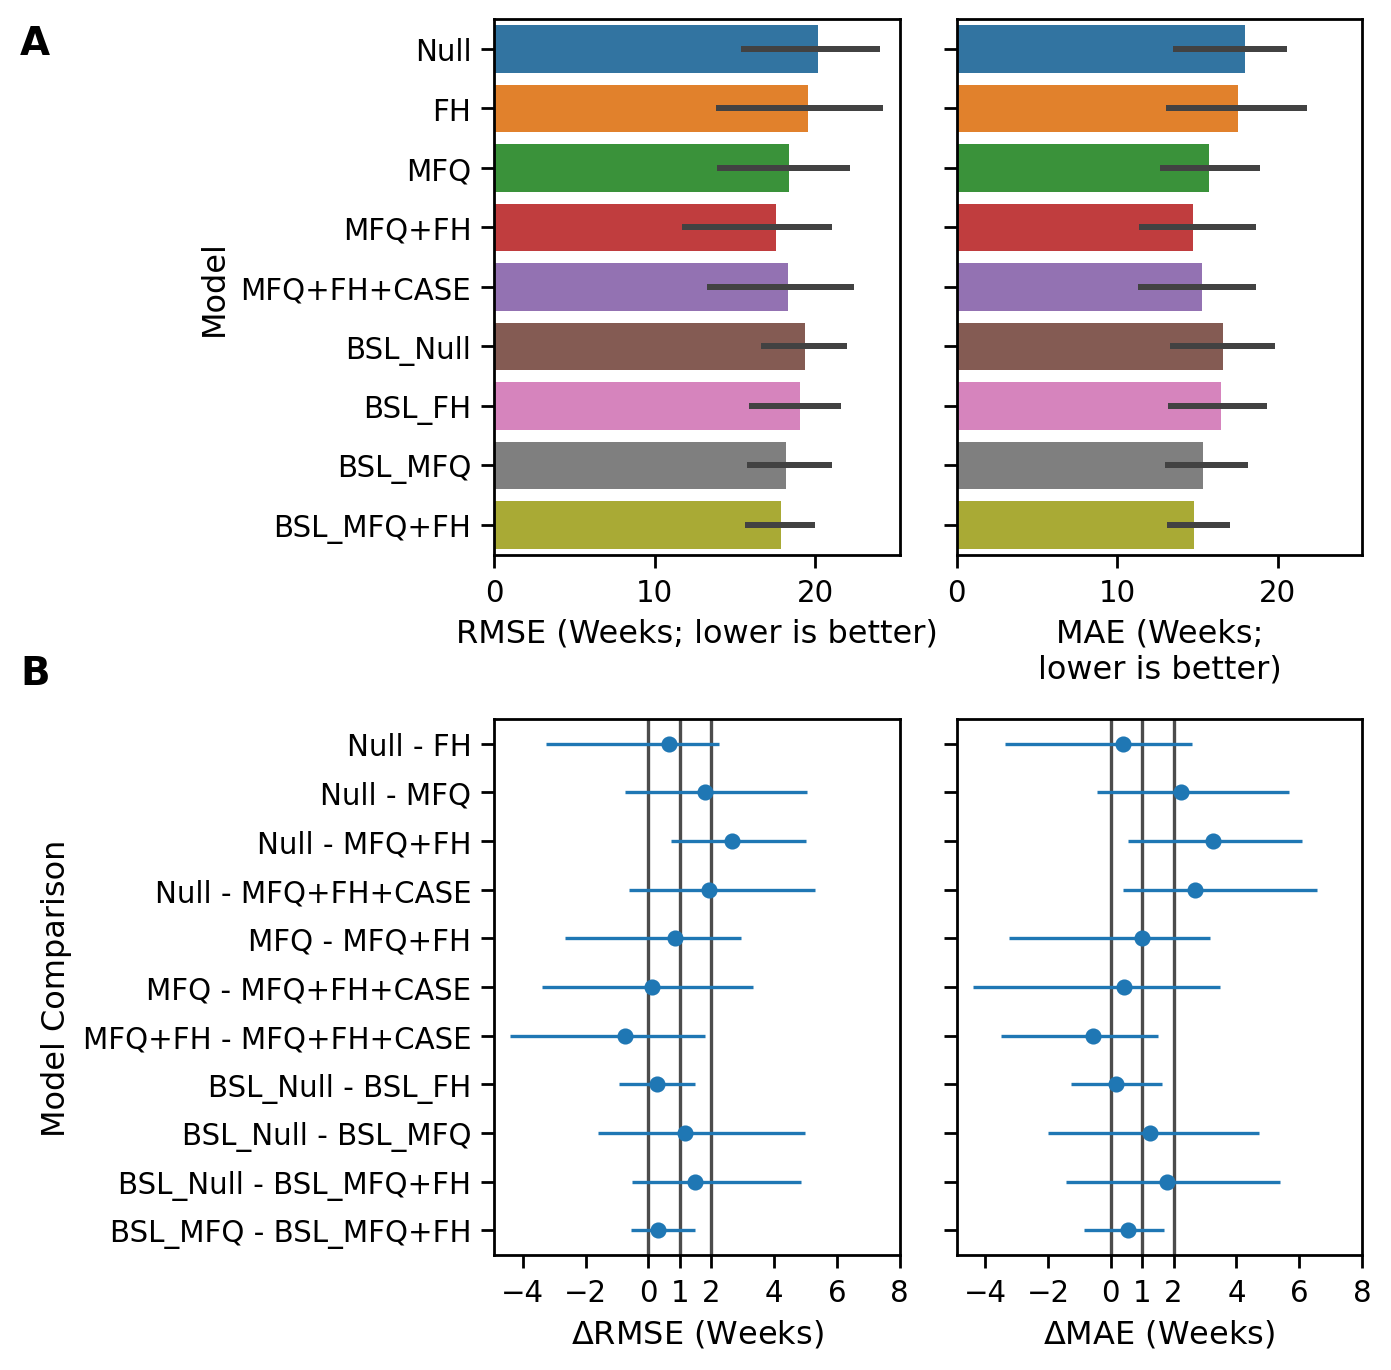

In [32]:
# supplement figure
to_plot_a = mf_agg
to_plot_a = to_plot_a.rename(columns = {
    'model': 'Model',
    'rmse': 'RMSE',
    'mae': 'MAE'
})

with sns.plotting_context("paper", font_scale=1.2, rc=paper_rc):

    fig, axes = plt.subplots(2,2, figsize=(7,7), sharex=False, dpi=200, 
                             )
    ax = axes[0,0]
    ax = sns.barplot(y="Model", x='RMSE', data=to_plot_a, order=model_names, ci=99.9, ax=ax)
    ax.set_xlabel('RMSE (Weeks; lower is better)')
    ax.get_figure().set_facecolor("white")
    a_xmin, a_xmax = ax.get_xlim()
    
    ax = axes[1,0]
    ax.errorbar(x=to_plot_cis.meanval,
                xerr=to_plot_cis.loc[:, [0.0005, 0.9995]].T.values,
                y=to_plot_cis.index.values,
                fmt='o')
    ax.set_yticks(to_plot_cis.index.values)
    ax.set_yticklabels(to_plot_cis['index'].values)
    ymin, ymax = ax.get_ylim()
    ax.vlines([0, 1, 2], ymin, ymax,colors='black', zorder=-10, alpha =0.7)
    ax.set_ylim((ymin, ymax))
    ax.set_ylabel('Model Comparison')
    ax.set_xticks([-4, -2, 0, 1, 2, 4, 6, 8])
    ax.set_xlabel('$\Delta$RMSE (Weeks)')
    b_xmin, b_xmax = ax.get_xlim()

    
    ax = axes[0,1]
    ax = sns.barplot(y="Model", x='MAE', data=to_plot_a, order=model_names, ci=99.9, ax=ax)
    ax.set_xlabel('MAE (Weeks;\nlower is better)')
    ax.get_figure().set_facecolor("white")
    ax.set_yticklabels([])
    ax.set_ylabel(None)
    ax.set_xlim((a_xmin, a_xmax))
    #ax.set_xticks([0, 5, 10])

    ax = axes[1,1]
    ax.errorbar(x=to_plot_mae_cis.meanval,
                xerr=to_plot_mae_cis.loc[:, [0.0005, 0.9995]].T.values,
                y=to_plot_mae_cis.index.values,
                fmt='o')
    ax.set_yticks(to_plot_mae_cis.index.values)
    ax.set_yticklabels([])
    ymin, ymax = ax.get_ylim()
    ax.vlines([0, 1, 2], ymin, ymax,colors='black', zorder=-10, alpha =0.7)
    ax.set_ylim((ymin, ymax))
    ax.set_xticks([-4, -2, 0, 1, 2, 4, 6, 8])
    ax.set_xlabel('$\Delta$MAE (Weeks)')
    ax.set_xlim((b_xmin, b_xmax))

    fig.set_facecolor('white')
    fig.tight_layout()
    fig.text(0.01, 0.95, 'A', fontsize=14, fontweight='bold')
    fig.text(0.01, 0.5, 'B', fontsize=14, fontweight='bold')

## Calculate differences

In [33]:
pairwise_res_mean = pairwise_res.query("metric == 'rmse'").groupby('bsi').mean()
pairwise_res_mean_mae = pairwise_res.query("metric == 'mae'").groupby('bsi').mean()

### Does family history improve any models by more than 1 week

In [34]:
len(pairwise_res_mean)

6435

In [35]:
difs = [
     ('Null - FH'),
     ('MFQ - MFQ+FH'),
]
value = 1
weeks_fh_improve_test = (((pairwise_res_mean.loc[:, difs].max(1) > value).sum())) / len(pairwise_res_mean)
print("RMSE test of FH improvement by more than 1 week:", weeks_fh_improve_test)
weeks_fh_improve_test_mae = (((pairwise_res_mean_mae.loc[:, difs].max(1) > value).sum())) / len(pairwise_res_mean_mae)
print("MAE test of FH improvement by more than 1 week:", weeks_fh_improve_test_mae)

print("0 corresponds to a bootstrap result of p < ", 1/len(pairwise_res_mean_mae))

difs = [
     ('BSL_Null - BSL_FH'),
     ('BSL_MFQ - BSL_MFQ+FH'),
]
weeks_fh_improve_test = (((pairwise_res_mean.loc[:, difs].max(1) > value).sum())) / len(pairwise_res_mean)

print("RMSE test of FH improvement by more than 1 week for BSL models:", weeks_fh_improve_test)

weeks_fh_improve_test_mae = (((pairwise_res_mean_mae.loc[:, difs].max(1) > value).sum())) / len(pairwise_res_mean_mae)

print("MAE test of FH improvement by more than 1 week for BSL models:", weeks_fh_improve_test_mae)


RMSE test of FH improvement by more than 1 week: 0.505982905982906
MAE test of FH improvement by more than 1 week: 0.5549339549339549
0 corresponds to a bootstrap result of p <  0.0001554001554001554
RMSE test of FH improvement by more than 1 week for BSL models: 0.05625485625485625
MAE test of FH improvement by more than 1 week for BSL models: 0.15104895104895105


### Does family history improve FMSE by more than 6 weeks

In [36]:
difs = [
     ('Null - FH'),
     ('MFQ - MFQ+FH'),
]
value = 4
weeks_fh_improve_test = (((pairwise_res_mean.loc[:, difs].max(1) > value).sum())) / len(pairwise_res_mean)
print("RMSE test of FH improvement by more than 4 weeks:", weeks_fh_improve_test)

RMSE test of FH improvement by more than 4 weeks: 0.0


In [37]:
weeks_fh_improve_test_mae = (((pairwise_res_mean_mae.loc[:, difs].max(1) > value).sum())) / len(pairwise_res_mean_mae)
print("MAE test of FH improvement by more than 4 weeks:", weeks_fh_improve_test_mae)

MAE test of FH improvement by more than 4 weeks: 0.0


### Does the case improve RMSE more than 2 weeks, or MAE more than 1

In [38]:
difs = ['MFQ+FH - MFQ+FH+CASE',]
value = 2
weeks_case_improve_test = (((pairwise_res_mean.loc[:, difs].max(1) > value).sum())) / len(pairwise_res_mean)

print("RMSE test of CASE improvement by more than 2 weeks:", weeks_case_improve_test)

value = 2
weeks_case_improve_test_mae = (((pairwise_res_mean_mae.loc[:, difs].max(1) > value).sum())) / len(pairwise_res_mean)
print("MAE test of CASE improvement by more than 2 week:", weeks_case_improve_test_mae)


RMSE test of CASE improvement by more than 2 weeks: 0.0001554001554001554
MAE test of CASE improvement by more than 2 week: 0.0


### are any model comparisons >1 under MAE

In [39]:
all_difs = to_plot_mae_cis['index'].values
value = 6
all_mae_improve_test = (((pairwise_res_mean_mae.loc[:, all_difs].max(1) > value).sum())) / len(pairwise_res_mean)
print("MAE test of any improvement by more than 6 week:", all_mae_improve_test)


MAE test of any improvement by more than 6 week: 0.00404040404040404


### Do all models have an RMSE more than 10 weeks

In [40]:
value = 10
weeks_models_rmse_test = (((pairwise_res_mean.loc[:, model_names].min(1) < value).sum())) / len(pairwise_res_mean)
print("RMSE test of any improvement by more than 1 week:", weeks_models_rmse_test)


RMSE test of any improvement by more than 1 week: 0.0009324009324009324


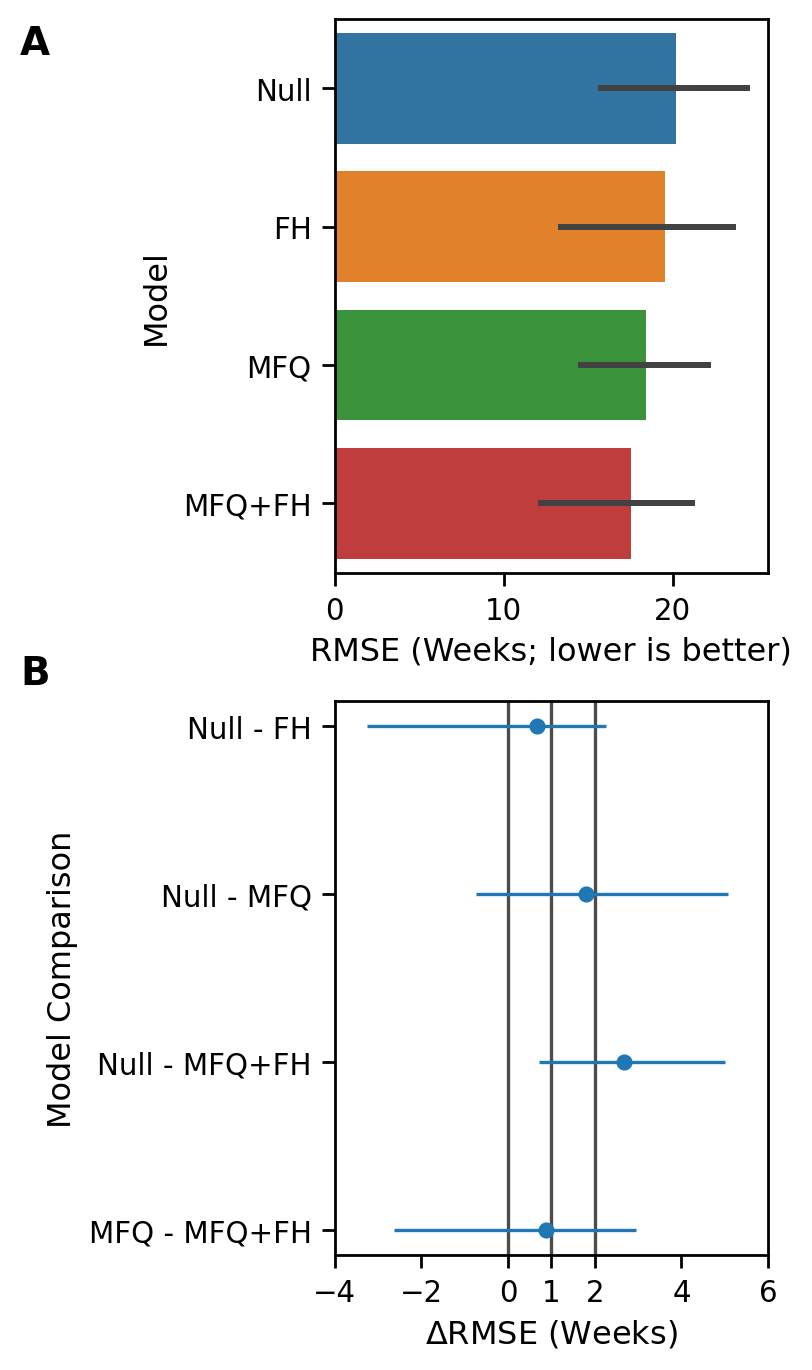

In [41]:
# main figure
main_models = ['FH', 'MFQ', 'MFQ+FH', 'Null']
to_plot_a = to_plot_a.loc[to_plot_a.Model.isin(main_models)]
main_difs = ['MFQ - MFQ+FH', 'Null - MFQ+FH', 'Null - MFQ', 'Null - FH']
to_plot_cis = to_plot_cis[to_plot_cis['index'].isin(main_difs)].reset_index(drop=True)
to_plot_mae_cis = to_plot_mae_cis[to_plot_mae_cis['index'].isin(main_difs)].reset_index(drop=True)

main_model_names = ['Null', 'FH', 'MFQ', 'MFQ+FH']
# with sns.plotting_context("paper", font_scale=1.2, rc=paper_rc):

#     fig, axes = plt.subplots(2,1, figsize=(5,7), sharex=False, dpi=200)
#     ax = axes[0]
#     ax = sns.barplot(y="Model", x='RMSE', data=to_plot_a, order=main_model_names, ci=99.9, ax=ax)
#     ax.set_xlabel('RMSE (Weeks; lower is better)')
#     ax.get_figure().set_facecolor("white")

#     ax = axes[1]
#     ax.errorbar(x=to_plot_cis.meanval,
#                 xerr=to_plot_cis.loc[:, [0.0005, 0.9995]].T.values,
#                 y=to_plot_cis.index.values,
#                 fmt='o')
#     ax.set_yticks(to_plot_cis.index.values)
#     ax.set_yticklabels(to_plot_cis['index'].values)
#     ymin, ymax = ax.get_ylim()
#     ax.vlines([0, 1, 2], ymin, ymax,colors='black', zorder=-10, alpha =0.7)
#     ax.set_ylim((ymin, ymax))
#     ax.set_ylabel('Model Comparison')
#     ax.set_xticks([-2, -1, 0, 1, 2])
#     ax.set_xticks([-2, -1, 0, 1, 2])
#     ax.set_xlabel('$\Delta$RMSE (Weeks)')

#     fig.set_facecolor('white')
#     fig.tight_layout()
#     fig.text(0.01, 0.95, 'A', fontsize=14, fontweight='bold')
#     fig.text(0.01, 0.5, 'B', fontsize=14, fontweight='bold')
# fig.savefig('weekly_main.pdf')

with sns.plotting_context("paper", font_scale=1.2, rc=paper_rc):

    fig, axes = plt.subplots(2,1, figsize=(4,7), sharex=False, dpi=200,)
    ax = axes[0]
    ax = sns.barplot(y="Model", x='RMSE', data=to_plot_a, order=main_model_names, ci=99.9, ax=ax)
    ax.set_xlabel('RMSE (Weeks; lower is better)')
    ax.get_figure().set_facecolor("white")
    a_xmin, a_xmax = ax.get_xlim()
    
    ax = axes[1]
    ax.errorbar(x=to_plot_cis.meanval,
                xerr=to_plot_cis.loc[:, [0.0005, 0.9995]].T.values,
                y=to_plot_cis.index.values,
                fmt='o')
    ax.set_yticks(to_plot_cis.index.values)
    ax.set_yticklabels(to_plot_cis['index'].values)
    ymin, ymax = ax.get_ylim()
    ax.vlines([0, 1, 2], ymin, ymax,colors='black', zorder=-10, alpha =0.7)
    ax.set_ylim((ymin, ymax))
    ax.set_ylabel('Model Comparison')
    ax.set_xticks([-4, -2, 0, 1, 2, 4, 6])
    ax.set_xlabel('$\Delta$RMSE (Weeks)')
    b_xmin, b_xmax = ax.get_xlim()

    
#     ax = axes[0,1]
#     ax = sns.barplot(y="Model", x='MAE', data=to_plot_a, order=main_model_names, ci=99.9, ax=ax)
#     ax.set_xlabel('MAE (Weeks;\nlower is better)')
#     ax.get_figure().set_facecolor("white")
#     ax.set_yticklabels([])
#     ax.set_ylabel(None)
#     ax.set_xlim((0, 10.5))
#     ax.set_xticks([0,5, 10])

#     ax = axes[1,1]
#     ax.errorbar(x=to_plot_mae_cis.meanval,
#                 xerr=to_plot_mae_cis.loc[:, [0.0005, 0.9995]].T.values,
#                 y=to_plot_mae_cis.index.values,
#                 fmt='o')
#     ax.set_yticks(to_plot_mae_cis.index.values)
#     ax.set_yticklabels([])
#     ymin, ymax = ax.get_ylim()
#     ax.vlines([0, 1, 2], ymin, ymax,colors='black', zorder=-10, alpha =0.7)
#     ax.set_ylim((ymin, ymax))
#     ax.set_xticks([-2, 0, 1, 2])
#     ax.set_xlabel('$\Delta$MAE (Weeks)')
#     ax.set_xlim((-2.45, 2.45))

    fig.set_facecolor('white')
    fig.tight_layout()
    fig.text(0.01, 0.95, 'A', fontsize=14, fontweight='bold')
    fig.text(0.01, 0.5, 'B', fontsize=14, fontweight='bold')
fig.savefig('weekly_main.pdf')

In [42]:
doi_names

['Null - FH',
 'Null - MFQ',
 'Null - MFQ+FH',
 'Null - MFQ+FH+CASE',
 'MFQ - MFQ+FH',
 'MFQ - MFQ+FH+CASE',
 'MFQ+FH - MFQ+FH+CASE',
 'BSL_Null - BSL_FH',
 'BSL_Null - BSL_MFQ',
 'BSL_Null - BSL_MFQ+FH',
 'BSL_MFQ - BSL_MFQ+FH']

In [43]:
difs = [
     ('Null - FH'),
     ('MFQ - MFQ+FH'),
]

In [44]:
pairwise_res.query('metric == "rmse"')

,bsi,bsfold,metric,Null,FH,MFQ,MFQ+FH,MFQ+FH+CASE,BSL_Null,BSL_FH,BSL_MFQ,BSL_MFQ+FH,Null - FH,Null - MFQ,Null - MFQ+FH,Null - MFQ+FH+CASE,MFQ - MFQ+FH,MFQ - MFQ+FH+CASE,MFQ+FH - MFQ+FH+CASE,BSL_Null - BSL_FH,BSL_Null - BSL_MFQ,BSL_Null - BSL_MFQ+FH,BSL_MFQ - BSL_MFQ+FH
0,0,0,rmse,23.699958,24.055340,18.269027,18.397458,17.904348,22.332656,22.433547,16.833270,16.979731,-0.355382,5.430931,5.302500,5.795610,-0.128431,0.364679,0.493110,-0.100891,5.499386,5.352925,-0.146461
2,0,1,rmse,20.406772,24.264523,16.262530,19.441708,19.841677,21.740161,22.676519,19.112070,19.669553,-3.857752,4.144242,0.965064,0.565095,-3.179178,-3.579147,-0.399969,-0.936358,2.628091,2.070608,-0.557483
4,0,2,rmse,19.486305,18.068547,18.651008,16.938965,16.044331,21.055076,19.729630,22.946477,21.676593,1.417759,0.835297,2.547340,3.441975,1.712043,2.606677,0.894634,1.325446,-1.891401,-0.621517,1.269884
6,0,3,rmse,18.114360,17.469434,17.712506,16.696012,17.521390,16.799470,17.740257,15.061669,15.332986,0.644926,0.401854,1.418349,0.592971,1.016495,0.191117,-0.825378,-0.940787,1.737801,1.466484,-0.271317
8,0,4,rmse,18.114360,17.469434,17.712506,16.696012,17.521390,16.799470,17.740257,15.061669,15.332986,0.644926,0.401854,1.418349,0.592971,1.016495,0.191117,-0.825378,-0.940787,1.737801,1.466484,-0.271317
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
102950,6434,3,rmse,23.699958,24.055340,18.269027,18.397458,17.904348,22.332656,22.433547,16.833270,16.979731,-0.355382,5.430931,5.302500,5.795610,-0.128431,0.364679,0.493110,-0.100891,5.499386,5.352925,-0.146461
102952,6434,4,rmse,19.486305,18.068547,18.651008,16.938965,16.044331,21.055076,19.729630,22.946477,21.676593,1.417759,0.835297,2.547340,3.441975,1.712043,2.606677,0.894634,1.325446,-1.891401,-0.621517,1.269884
102954,6434,5,rmse,19.486305,18.068547,18.651008,16.938965,16.044331,21.055076,19.729630,22.946477,21.676593,1.417759,0.835297,2.547340,3.441975,1.712043,2.606677,0.894634,1.325446,-1.891401,-0.621517,1.269884
102956,6434,6,rmse,19.486305,18.068547,18.651008,16.938965,16.044331,21.055076,19.729630,22.946477,21.676593,1.417759,0.835297,2.547340,3.441975,1.712043,2.606677,0.894634,1.325446,-1.891401,-0.621517,1.269884


In [45]:
(((pairwise_res.query('metric == "rmse"').groupby('bsi').mean().loc[:, difs].max(1) > 1).sum())) / len(pairwise_res.query('metric == "rmse"').bsi.unique()), len(pairwise_res.query('metric == "rmse"').bsi.unique())

(0.505982905982906, 6435)

In [46]:
difs = [
     'MFQ+FH - MFQ+FH+CASE'
]

In [47]:
(((pairwise_res.query('metric == "rmse"').groupby('bsi').mean().loc[:, difs].max(1) > 1).sum())) / len(pairwise_res.query('metric == "rmse"').bsi.unique()), len(pairwise_res.query('metric == "rmse"').bsi.unique())

(0.018648018648018648, 6435)

In [48]:
reses.to_csv('../data/weekly_cv_predictions.csv', index=None)


In [49]:
## fit models to everything
model_name = list(models.keys())[0]
print(f"Fitting {model_name} Model to all data, don't use these fit statistics.")
model = models[model_name]
mdl = smf.ols(model, wdat)
fitted = mdl.fit()
fitted.summary()

Fitting Null Model to all data, don't use these fit statistics.


<class 'statsmodels.iolib.summary.Summary'>
"""
                                   OLS Regression Results                                   
============================================================================================
Dep. Variable:     c_ksadsdx_epset_annual_weeks_mdd   R-squared:                       0.135
Model:                                          OLS   Adj. R-squared:                  0.025
Method:                               Least Squares   F-statistic:                     1.225
Date:                              Mon, 27 Sep 2021   Prob (F-statistic):              0.300
Time:                                      13:59:12   Log-Likelihood:                -305.71
No. Observations:                                72   AIC:                             629.4
Df Residuals:                                    63   BIC:                             649.9
Df Model:                                         8                                         
Covariance Type:                          nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept               -2.3387     26.526     -0.088      0.930     -55.346      50.668
SEX[T.MALE]             -3.5933      4.997     -0.719      0.475     -13.579       6.392
postpandemic[T.True]     5.1724      4.628      1.118      0.268      -4.075      14.420
BaselineAntiDep          1.0796      5.384      0.200      0.842      -9.680      11.840
BaselineOtherMeds      -10.3089      5.930     -1.738      0.087     -22.159       1.541
FUAntiDep                7.7612      5.376      1.444      0.154      -2.983      18.505
FUOtherMeds              2.3553      6.253      0.377      0.708     -10.141      14.852
Inpatient                6.6405      5.412      1.227      0.224      -4.174      17.455
Age_at_visit             1.1930      1.657      0.720      0.474      -2.117       4.503
==============================================================================
Omnibus:                        8.990   Durbin-Watson:                   1.896
Prob(Omnibus):                  0.011   Jarque-Bera (JB):                6.290
Skew:                           0.587   Prob(JB):                       0.0431
Kurtosis:                       2.153   Cond. No.                         199.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [50]:
## fit models to everything
model_name = list(models.keys())[1]
print(f"Fitting {model_name} Model to all data, don't use these fit statistics.")
model = models[model_name]
mdl = smf.ols(model, wdat)
fitted = mdl.fit()
fitted.summary()

Fitting FH Model to all data, don't use these fit statistics.


<class 'statsmodels.iolib.summary.Summary'>
"""
                                   OLS Regression Results                                   
============================================================================================
Dep. Variable:     c_ksadsdx_epset_annual_weeks_mdd   R-squared:                       0.206
Model:                                          OLS   Adj. R-squared:                  0.091
Method:                               Least Squares   F-statistic:                     1.792
Date:                              Mon, 27 Sep 2021   Prob (F-statistic):             0.0877
Time:                                      13:59:12   Log-Likelihood:                -302.59
No. Observations:                                72   AIC:                             625.2
Df Residuals:                                    62   BIC:                             647.9
Df Model:                                         9                                         
Covariance Type:                          nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept                3.3062     25.714      0.129      0.898     -48.096      54.708
SEX[T.MALE]             -3.5420      4.823     -0.734      0.466     -13.184       6.100
postpandemic[T.True]     5.4390      4.468      1.217      0.228      -3.493      14.371
dep_immed               11.0589      4.666      2.370      0.021       1.732      20.386
BaselineAntiDep          0.4843      5.203      0.093      0.926      -9.917      10.886
BaselineOtherMeds       -9.4934      5.734     -1.656      0.103     -20.956       1.969
FUAntiDep                7.5272      5.191      1.450      0.152      -2.849      17.903
FUOtherMeds              2.1960      6.037      0.364      0.717      -9.871      14.263
Inpatient                6.3499      5.225      1.215      0.229      -4.095      16.794
Age_at_visit             0.3528      1.638      0.215      0.830      -2.921       3.627
==============================================================================
Omnibus:                        6.398   Durbin-Watson:                   1.810
Prob(Omnibus):                  0.041   Jarque-Bera (JB):                3.654
Skew:                           0.351   Prob(JB):                        0.161
Kurtosis:                       2.148   Cond. No.                         201.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [51]:
## fit models to everything
model_name = list(models.keys())[2]
print(f"Fitting {model_name} Model to all data, don't use these fit statistics.")
model = models[model_name]
mdl = smf.ols(model, wdat)
fitted = mdl.fit()
fitted.summary()

Fitting MFQ Model to all data, don't use these fit statistics.


<class 'statsmodels.iolib.summary.Summary'>
"""
                                   OLS Regression Results                                   
============================================================================================
Dep. Variable:     c_ksadsdx_epset_annual_weeks_mdd   R-squared:                       0.289
Model:                                          OLS   Adj. R-squared:                  0.186
Method:                               Least Squares   F-statistic:                     2.799
Date:                              Mon, 27 Sep 2021   Prob (F-statistic):            0.00802
Time:                                      13:59:12   Log-Likelihood:                -298.64
No. Observations:                                72   AIC:                             617.3
Df Residuals:                                    62   BIC:                             640.0
Df Model:                                         9                                         
Covariance Type:                          nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept                2.5207     24.273      0.104      0.918     -46.000      51.042
SEX[T.MALE]             -4.8841      4.579     -1.067      0.290     -14.038       4.270
postpandemic[T.True]     5.6478      4.230      1.335      0.187      -2.808      14.104
BaselineMFQScore         1.1642      0.317      3.669      0.001       0.530       1.799
BaselineAntiDep          6.6089      5.146      1.284      0.204      -3.677      16.895
BaselineOtherMeds      -13.2707      5.478     -2.423      0.018     -24.221      -2.320
FUAntiDep                4.0572      5.015      0.809      0.422      -5.968      14.082
FUOtherMeds              2.7661      5.715      0.484      0.630      -8.658      14.190
Inpatient                2.2505      5.087      0.442      0.660      -7.919      12.420
Age_at_visit             0.1302      1.541      0.085      0.933      -2.950       3.211
==============================================================================
Omnibus:                        4.674   Durbin-Watson:                   1.902
Prob(Omnibus):                  0.097   Jarque-Bera (JB):                4.668
Skew:                           0.606   Prob(JB):                       0.0969
Kurtosis:                       2.704   Cond. No.                         254.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [52]:
## fit models to everything
model_name = list(models.keys())[3]
print(f"Fitting {model_name} Model to all data, don't use these fit statistics.")
model = models[model_name]
mdl = smf.ols(model, wdat)
fitted = mdl.fit()
fitted.summary()

Fitting MFQ+FH Model to all data, don't use these fit statistics.


<class 'statsmodels.iolib.summary.Summary'>
"""
                                   OLS Regression Results                                   
============================================================================================
Dep. Variable:     c_ksadsdx_epset_annual_weeks_mdd   R-squared:                       0.365
Model:                                          OLS   Adj. R-squared:                  0.261
Method:                               Least Squares   F-statistic:                     3.508
Date:                              Mon, 27 Sep 2021   Prob (F-statistic):            0.00106
Time:                                      13:59:12   Log-Likelihood:                -294.56
No. Observations:                                72   AIC:                             611.1
Df Residuals:                                    61   BIC:                             636.2
Df Model:                                        10                                         
Covariance Type:                          nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept                8.3990     23.225      0.362      0.719     -38.043      54.841
SEX[T.MALE]             -4.8493      4.362     -1.112      0.271     -13.573       3.874
postpandemic[T.True]     5.9288      4.031      1.471      0.147      -2.132      13.990
BaselineMFQScore         1.1804      0.302      3.904      0.000       0.576       1.785
dep_immed               11.3839      4.208      2.705      0.009       2.969      19.799
BaselineAntiDep          6.0730      4.906      1.238      0.220      -3.737      15.883
BaselineOtherMeds      -12.4724      5.227     -2.386      0.020     -22.925      -2.020
FUAntiDep                3.7649      4.779      0.788      0.434      -5.791      13.321
FUOtherMeds              2.6079      5.445      0.479      0.634      -8.279      13.495
Inpatient                1.8904      4.848      0.390      0.698      -7.804      11.585
Age_at_visit            -0.7494      1.504     -0.498      0.620      -3.756       2.257
==============================================================================
Omnibus:                        2.756   Durbin-Watson:                   1.849
Prob(Omnibus):                  0.252   Jarque-Bera (JB):                2.682
Skew:                           0.455   Prob(JB):                        0.262
Kurtosis:                       2.743   Cond. No.                         256.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [53]:
## fit models to everything
model_name = list(models.keys())[4]
print(f"Fitting {model_name} Model to all data, don't use these fit statistics.")
model = models[model_name]
mdl = smf.ols(model, wdat)
fitted = mdl.fit()
fitted.summary()

Fitting MFQ+FH+CASE Model to all data, don't use these fit statistics.


<class 'statsmodels.iolib.summary.Summary'>
"""
                                   OLS Regression Results                                   
============================================================================================
Dep. Variable:     c_ksadsdx_epset_annual_weeks_mdd   R-squared:                       0.418
Model:                                          OLS   Adj. R-squared:                  0.300
Method:                               Least Squares   F-statistic:                     3.538
Date:                              Mon, 27 Sep 2021   Prob (F-statistic):           0.000557
Time:                                      13:59:12   Log-Likelihood:                -291.40
No. Observations:                                72   AIC:                             608.8
Df Residuals:                                    59   BIC:                             638.4
Df Model:                                        12                                         
Covariance Type:                          nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept                    11.8771     23.300      0.510      0.612     -34.746      58.500
SEX[T.MALE]                  -3.9696      4.287     -0.926      0.358     -12.548       4.609
postpandemic[T.True]          5.5653      3.928      1.417      0.162      -2.294      13.424
BaselineMFQScore              0.9229      0.322      2.868      0.006       0.279       1.567
dep_immed                     7.5806      7.269      1.043      0.301      -6.965      22.126
s_case__neg_tot               0.4139      1.256      0.330      0.743      -2.099       2.926
dep_immed:s_case__neg_tot     0.9009      1.333      0.676      0.502      -1.767       3.568
BaselineAntiDep               5.5988      5.130      1.091      0.280      -4.667      15.864
BaselineOtherMeds           -10.7398      5.158     -2.082      0.042     -21.060      -0.419
FUAntiDep                     4.0036      4.938      0.811      0.421      -5.877      13.885
FUOtherMeds                   0.9491      5.350      0.177      0.860      -9.757      11.655
Inpatient                     3.8428      4.920      0.781      0.438      -6.003      13.688
Age_at_visit                 -0.9440      1.467     -0.644      0.522      -3.879       1.991
==============================================================================
Omnibus:                        4.020   Durbin-Watson:                   1.670
Prob(Omnibus):                  0.134   Jarque-Bera (JB):                3.735
Skew:                           0.489   Prob(JB):                        0.155
Kurtosis:                       2.462   Cond. No.                         275.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [54]:
## fit models to everything
model_name = list(models.keys())[5]
print(f"Fitting {model_name} Model to all data, don't use these fit statistics.")
model = models[model_name]
mdl = smf.ols(model, pure_dat)
fitted = mdl.fit()
fitted.summary()

Fitting BSL_Null Model to all data, don't use these fit statistics.


<class 'statsmodels.iolib.summary.Summary'>
"""
                                   OLS Regression Results                                   
============================================================================================
Dep. Variable:     c_ksadsdx_epset_annual_weeks_mdd   R-squared:                       0.051
Model:                                          OLS   Adj. R-squared:                 -0.004
Method:                               Least Squares   F-statistic:                    0.9228
Date:                              Mon, 27 Sep 2021   Prob (F-statistic):              0.470
Time:                                      13:59:12   Log-Likelihood:                -397.04
No. Observations:                                92   AIC:                             806.1
Df Residuals:                                    86   BIC:                             821.2
Df Model:                                         5                                         
Covariance Type:                          nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept               -3.1611     22.995     -0.137      0.891     -48.873      42.551
SEX[T.MALE]              0.1471      4.371      0.034      0.973      -8.542       8.837
postpandemic[T.True]     6.6067      4.043      1.634      0.106      -1.430      14.643
BaselineAntiDep          3.7323      4.564      0.818      0.416      -5.341      12.806
BaselineOtherMeds       -5.1451      4.942     -1.041      0.301     -14.969       4.679
Age_at_visit             1.4280      1.429      1.000      0.320      -1.412       4.268
==============================================================================
Omnibus:                       17.956   Durbin-Watson:                   1.936
Prob(Omnibus):                  0.000   Jarque-Bera (JB):                6.222
Skew:                           0.356   Prob(JB):                       0.0446
Kurtosis:                       1.944   Cond. No.                         188.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

# deal with mfq point to point predictions

In [55]:
mdat = pd.read_csv('../data/MFQAnalysesDatabaseforDylan.csv', index_col=0).reset_index(drop=True)
bsl_mfqs = mdat.sort_values(['SDAN', 'Clinical_Visit_Date']).groupby('SDAN')[['MFQtminus1']].first().reset_index().rename(columns={'MFQtminus1':'baseline_mfq'})
mdat = mdat.merge(bsl_mfqs, how='left', on='SDAN')


In [56]:
mdat.loc[mdat.SDAN == mdat.loc[mdat.TimeBetween>800, 'SDAN'].values[0], :]

,SDAN,Participant_Type2,Clinical_Visit_Date,PreviousVisitDate,s_mfq_tot,MFQtminus1,antidepressants,OtherMeds,InpatientDuring,postpandemic,Age_at_visit,PreviousAge,SEX,dep_immed,TimeBetween,baseline_mfq
511,23501,MDD,8/26/20,3/10/18,5.0,8.0,0,0,False,True,16.39,13.93,FEMALE,0,900,8.0


In [57]:
mdat.loc[mdat.SDAN == 23501]

,SDAN,Participant_Type2,Clinical_Visit_Date,PreviousVisitDate,s_mfq_tot,MFQtminus1,antidepressants,OtherMeds,InpatientDuring,postpandemic,Age_at_visit,PreviousAge,SEX,dep_immed,TimeBetween,baseline_mfq
511,23501,MDD,8/26/20,3/10/18,5.0,8.0,0,0,False,True,16.39,13.93,FEMALE,0,900,8.0


In [58]:
mdat.SDAN.nunique()

130

In [59]:
mdat = mdat.loc[mdat.TimeBetween<800].reset_index(drop=True)
mdat.max()

SDAN                     24378
Participant_Type2          MDD
Clinical_Visit_Date     9/9/19
PreviousVisitDate       9/9/19
s_mfq_tot              26.0079
MFQtminus1             26.0079
antidepressants              1
OtherMeds                    1
InpatientDuring           True
postpandemic              True
Age_at_visit             20.67
PreviousAge              20.58
SEX                       MALE
dep_immed                    1
TimeBetween                518
baseline_mfq                26
dtype: object

In [60]:
mdat.TimeBetween.mean(), mdat.TimeBetween.std()

(69.59236641221374, 80.56928047462456)

In [65]:
mdat.shape

(1310, 17)

In [66]:
mdat.shape[0]/mdat.SDAN.nunique()

10.155038759689923

In [67]:
mdat.groupby('SDAN').Participant_Type2.count().mean(), mdat.groupby('SDAN').Participant_Type2.count().std() 

(10.155038759689923, 6.709891965881303)

In [68]:
mdat.groupby('SDAN').Participant_Type2.count().quantile([0.25,0.50,0.75])

0.25     4.0
0.50    10.0
0.75    14.0
Name: Participant_Type2, dtype: float64

In [69]:
mdat.TimeBetween.quantile([0.25,0.50,0.75])

0.25     12.0
0.50     36.5
0.75    108.0
Name: TimeBetween, dtype: float64

In [70]:
108-12

96

In [71]:
mdat['TimeBetween'] = mdat.TimeBetween / 365
mdat['Time2'] = mdat.TimeBetween ** 2

In [72]:
(mdat.groupby('SDAN').Participant_Type2.count() + 1).mean(), (mdat.groupby('SDAN').Participant_Type2.count() + 1).std()

(11.155038759689923, 6.709891965881303)

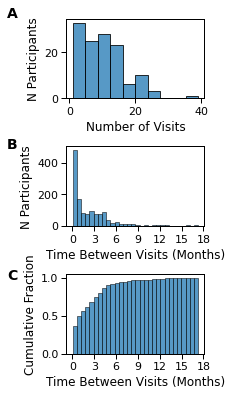

In [73]:
with sns.plotting_context("paper", font_scale=1.25, rc=paper_rc):

    fig, axs = plt.subplots(3,1, figsize=(3,5.5))
    ax = axs[0]

    ax = sns.histplot(mdat.groupby('SDAN').Participant_Type2.count(), ax=ax)
    ax.set_xlabel('Number of Visits')
    ax.set_ylabel('N Participants')

    ax = axs[1]
    ax = sns.histplot(mdat.TimeBetween*365/30, cumulative=False, ax=ax)
    ax.set_xticks([0,3,6, 9,12, 15, 18])
    ax.set_xlabel('Time Between Visits (Months)')
    ax.set_ylabel('N Participants')

    ax = axs[2]
    ax = sns.histplot(mdat.TimeBetween*365/30, cumulative=True, ax=ax, stat="probability")
    ax.set_ylabel('Cumulative Fraction')
    ax.set_xlabel('Time Between Visits (Months)')
    ax.set_xticks([0,3,6, 9,12, 15, 18])

    fig.text(0, 0.97, 'A', fontsize=14, fontweight='bold')
    fig.text(0, 0.64, 'B', fontsize=14, fontweight='bold')
    fig.text(0, 0.31, 'C', fontsize=14, fontweight='bold')
    fig.tight_layout()

    fig.set_facecolor('white')


In [74]:
models = {
    'Null': 's_mfq_tot ~ antidepressants + TimeBetween + InpatientDuring + Age_at_visit + SEX  + OtherMeds + postpandemic + (TimeBetween | SDAN)',
    'FH': 's_mfq_tot ~ dep_immed*TimeBetween + InpatientDuring + Age_at_visit + SEX + antidepressants + OtherMeds + postpandemic + (TimeBetween | SDAN)',
    'MFQ0': 's_mfq_tot ~ antidepressants + TimeBetween*baseline_mfq + InpatientDuring + Age_at_visit + SEX  + OtherMeds + postpandemic + (TimeBetween | SDAN)',
    'MFQ0+FH': 's_mfq_tot ~ antidepressants + TimeBetween*baseline_mfq + dep_immed + dep_immed:TimeBetween + InpatientDuring + Age_at_visit + SEX  + OtherMeds + postpandemic + (TimeBetween | SDAN)',    
    'MFQ': 's_mfq_tot ~ antidepressants + TimeBetween + MFQtminus1 + InpatientDuring + Age_at_visit + SEX  + OtherMeds + postpandemic + (TimeBetween | SDAN)',
    'MFQ+FH': 's_mfq_tot ~ dep_immed*TimeBetween + MFQtminus1 + InpatientDuring + Age_at_visit + SEX + antidepressants + OtherMeds + postpandemic + (TimeBetween | SDAN)',
    'MFQ+FH_T2': 's_mfq_tot ~ dep_immed*TimeBetween + dep_immed:Time2 + Time2 + MFQtminus1 + InpatientDuring + Age_at_visit + SEX + antidepressants + OtherMeds + postpandemic + (TimeBetween | SDAN)',
    'MFQ0+MFQ': 's_mfq_tot ~ antidepressants + TimeBetween*baseline_mfq + MFQtminus1 + InpatientDuring + Age_at_visit + SEX  + OtherMeds + postpandemic + (TimeBetween | SDAN)',
    'MFQ0+MFQ+FH': 's_mfq_tot ~ antidepressants + TimeBetween*baseline_mfq + dep_immed + dep_immed:TimeBetween + MFQtminus1 + InpatientDuring + Age_at_visit + SEX  + OtherMeds + postpandemic + (TimeBetween | SDAN)',
}
model_names = list(models.keys())

In [75]:
mdat['dep_immed:TimeBetween'] = mdat.dep_immed * mdat.TimeBetween
mdat['TimeBetween:dep_immed'] = mdat.dep_immed * mdat.TimeBetween
mdat['dep_immed:Time2'] = mdat.dep_immed * mdat.TimeBetween
mdat['TimeBetween:MFQtminus1'] = mdat.MFQtminus1 * mdat.TimeBetween
mdat['TimeBetween:baseline_mfq'] = mdat.baseline_mfq * mdat.TimeBetween

In [76]:
# make sure there aren't any nulls
assert mdat.isnull().sum().max() == 0
# make sure there are only MDDs in this group
assert mdat.Participant_Type2.unique()[0] == 'MDD'
# make sure there are only male and femal in the sex column
assert set(mdat.SEX.unique()) == {'FEMALE', 'MALE'}

In [77]:
mdat['InpatientDuring'] = mdat.InpatientDuring.astype(int)
mdat['postpandemic'] = mdat.postpandemic.astype(int)
mdat['SEX'] = (mdat.SEX == "MALE").astype(int)

In [78]:
mdat['Clinical_Visit_Date'] = pd.to_datetime(mdat.Clinical_Visit_Date)
print(mdat.loc[mdat.postpandemic == 0].Clinical_Visit_Date.min(), mdat.loc[mdat.postpandemic == 0].Clinical_Visit_Date.max())
print(mdat.loc[mdat.postpandemic == 1].Clinical_Visit_Date.min(), mdat.loc[mdat.postpandemic == 1].Clinical_Visit_Date.max())


2017-03-20 00:00:00 2020-03-17 00:00:00
2020-03-19 00:00:00 2021-05-04 00:00:00


In [79]:
models = {
    'Null': 's_mfq_tot ~ antidepressants + TimeBetween + InpatientDuring + Age_at_visit + SEX  + OtherMeds + postpandemic + (TimeBetween | SDAN)',
    'FH': 's_mfq_tot ~ dep_immed*TimeBetween + InpatientDuring + Age_at_visit + SEX + antidepressants + OtherMeds + postpandemic + (TimeBetween | SDAN)',
    'MFQ0': 's_mfq_tot ~ antidepressants + TimeBetween*baseline_mfq + InpatientDuring + Age_at_visit + SEX  + OtherMeds + postpandemic + (TimeBetween | SDAN)',
    'MFQ0+FH': 's_mfq_tot ~ antidepressants + TimeBetween*baseline_mfq + dep_immed + dep_immed:TimeBetween + InpatientDuring + Age_at_visit + SEX  + OtherMeds + postpandemic + (TimeBetween | SDAN)',    
    'MFQ': 's_mfq_tot ~ antidepressants + TimeBetween + MFQtminus1 + InpatientDuring + Age_at_visit + SEX  + OtherMeds + postpandemic + (TimeBetween | SDAN)',
    'MFQ+FH': 's_mfq_tot ~ dep_immed*TimeBetween + MFQtminus1 + InpatientDuring + Age_at_visit + SEX + antidepressants + OtherMeds + postpandemic + (TimeBetween | SDAN)',
    'MFQ+FH_T2': 's_mfq_tot ~ dep_immed*TimeBetween + dep_immed:Time2 + Time2 + MFQtminus1 + InpatientDuring + Age_at_visit + SEX + antidepressants + OtherMeds + postpandemic + (TimeBetween | SDAN)',
    'MFQ0+MFQ': 's_mfq_tot ~ antidepressants + TimeBetween*baseline_mfq + MFQtminus1 + InpatientDuring + Age_at_visit + SEX  + OtherMeds + postpandemic + (TimeBetween | SDAN)',
    'MFQ0+MFQ+FH': 's_mfq_tot ~ antidepressants + TimeBetween*baseline_mfq + dep_immed + dep_immed:TimeBetween + MFQtminus1 + InpatientDuring + Age_at_visit + SEX  + OtherMeds + postpandemic + (TimeBetween | SDAN)',
}

/tmp/ipykernel_48311/2504483304.py:36: RuntimeWarning: divide by zero encountered in arctanh
  within_z = np.arctanh(for_cors_visit.loc[for_cors_visit.SDAN.isin(visit_cor_mask.SDAN)].groupby('SDAN').corr()).reset_index()
/tmp/ipykernel_48311/2504483304.py:36: RuntimeWarning: invalid value encountered in arctanh
  within_z = np.arctanh(for_cors_visit.loc[for_cors_visit.SDAN.isin(visit_cor_mask.SDAN)].groupby('SDAN').corr()).reset_index()


Antidepressants at Baseline Other Meds at Baseline 0.5055364234397534 129 9.932090739085263e-10
Other Meds at Baseline Antidepressants at Baseline 0.5055364234397534 129 9.932090739085263e-10


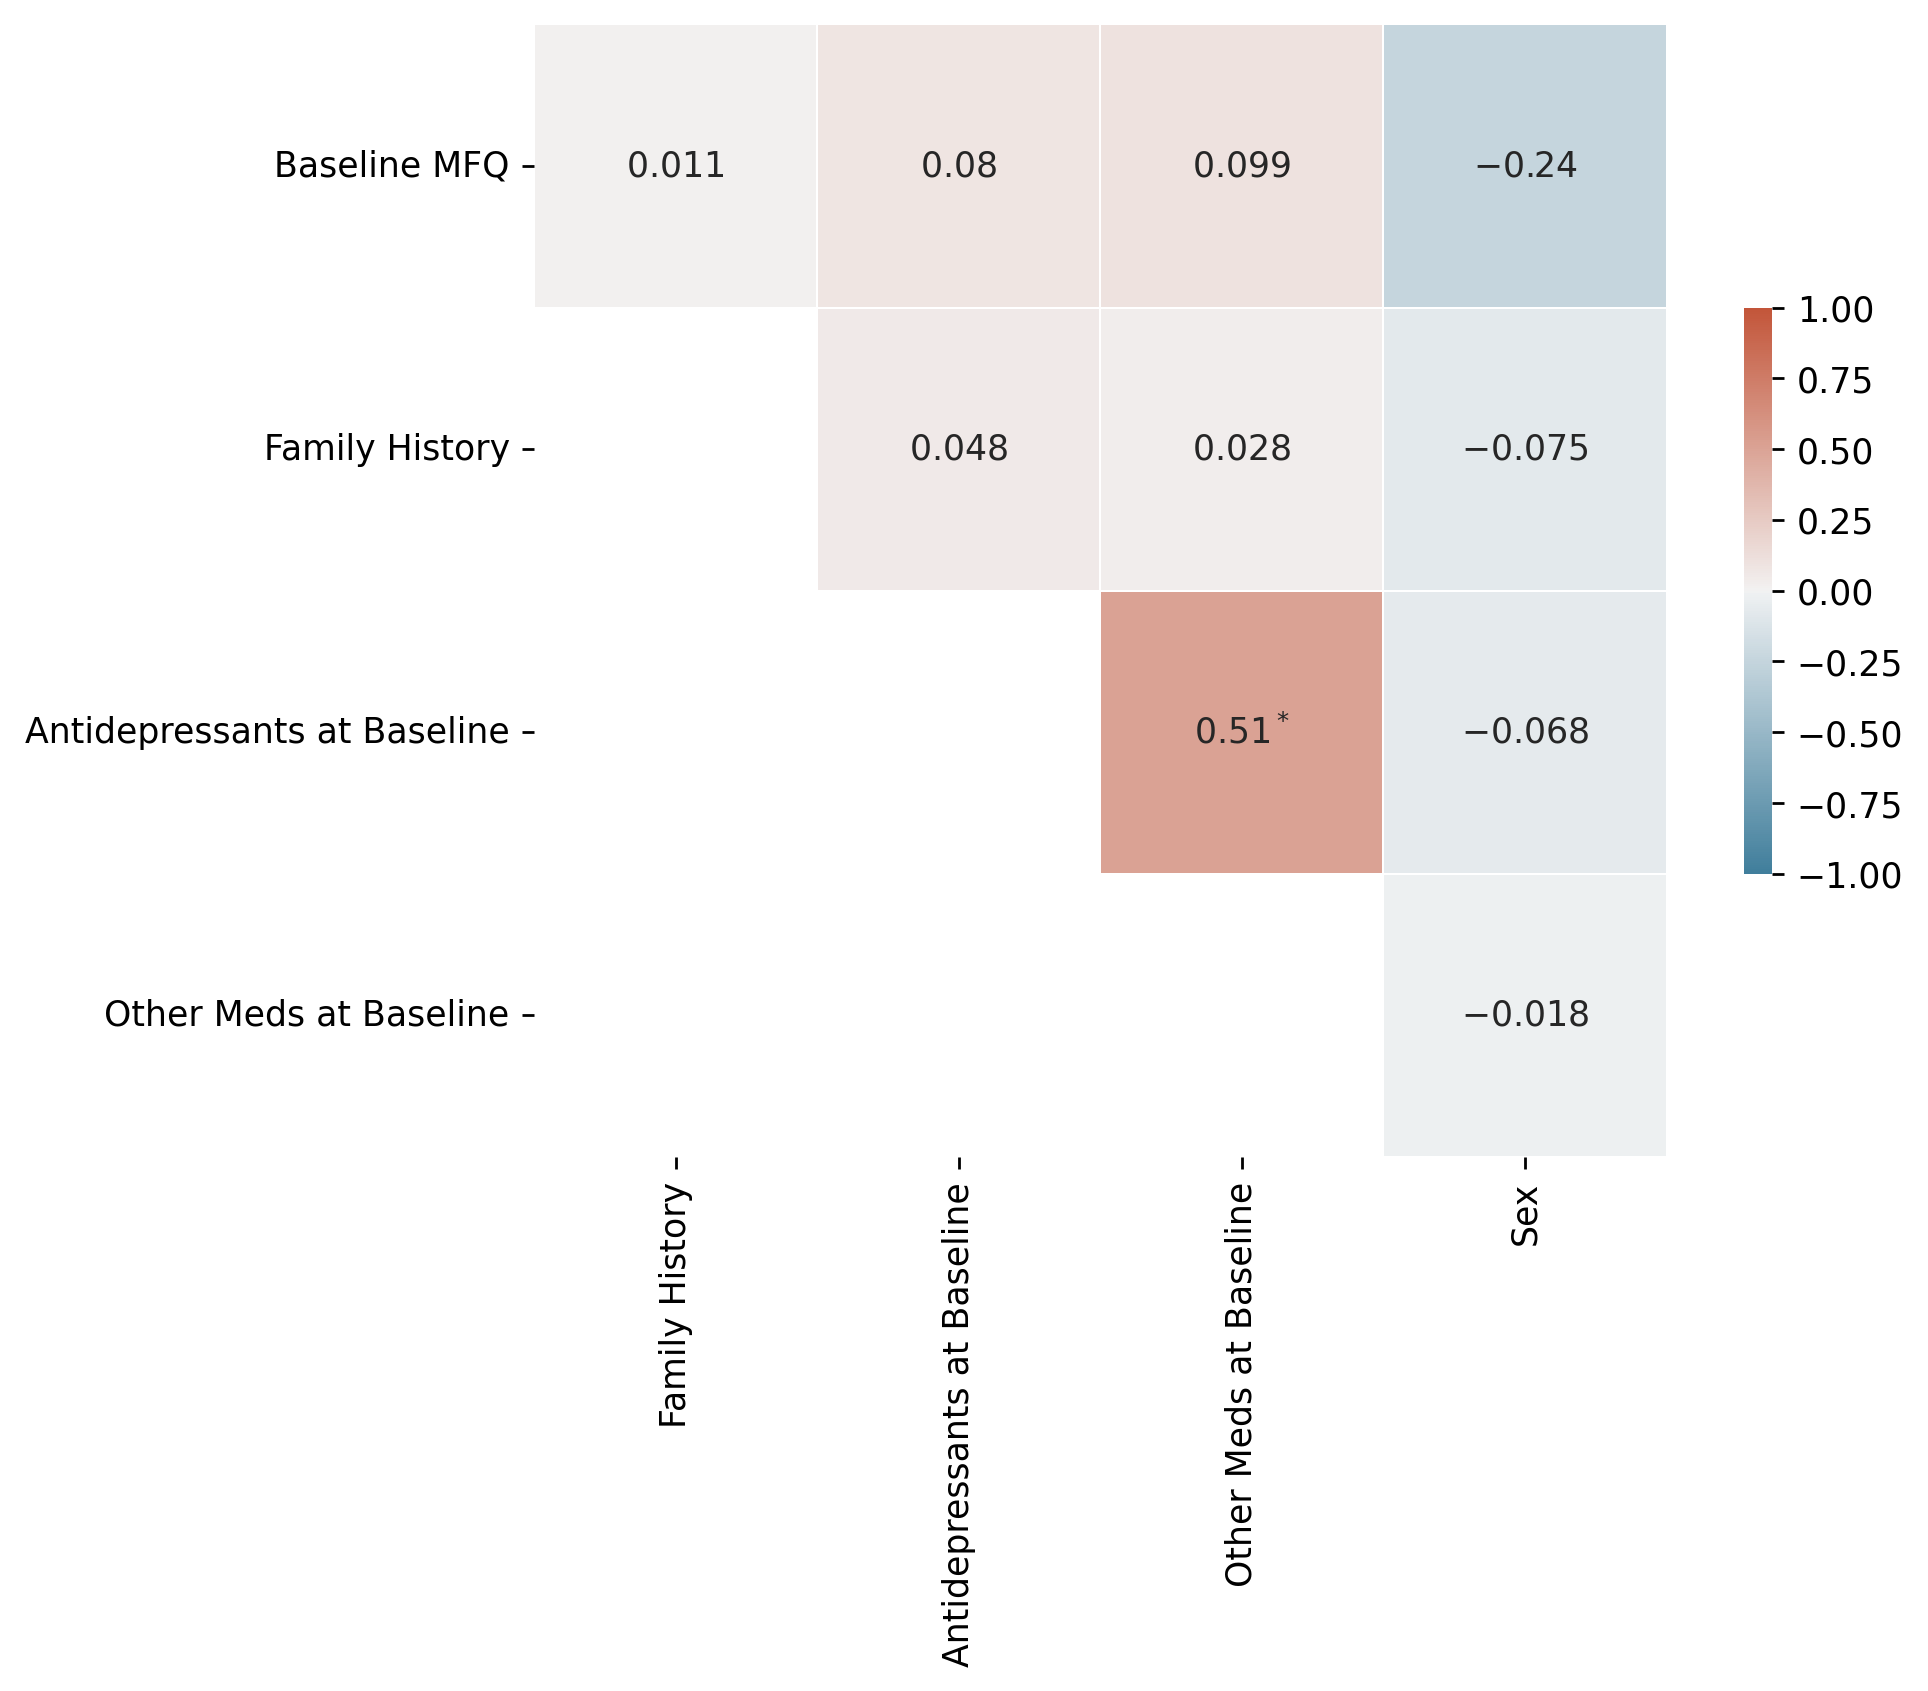

In [80]:
# Pairwise correlations for those factors that don't vary by visit pair
sub_terms = {
    "baseline_mfq": "Baseline MFQ",
    "dep_immed": "Family History",
    "antidepressants": "Antidepressants at Baseline",
    "OtherMeds": "Other Meds at Baseline",
    "SEX":"Sex",
}

visit_terms = {
    "s_mfq_tot": "Next MFQ",
    "MFQtminus1": "Previous MFQ",
    "Age_at_visit": "Age",
    "TimeBetween": "Interval",
    "postpandemic": "Pandemic",
    "InpatientDuring":"Inpatient",

}

all_terms = sub_terms.copy()
all_terms.update(visit_terms)

for_cors = mdat.loc[:, all_terms.keys()].copy()
for_cors = for_cors.rename(columns=all_terms)
corr = for_cors.corr()
mask = np.tril(np.ones_like(corr, dtype=bool))
                     
for_cors_sub = mdat.groupby("SDAN").first().loc[:, sub_terms.keys()].copy()
for_cors_sub = for_cors_sub.rename(columns=sub_terms)
corr_sub = for_cors_sub.corr()
mask_sub = np.tril(np.ones_like(corr_sub, dtype=bool))

for_cors_visit = mdat.loc[:, list(visit_terms.keys()) + ['SDAN']].copy()
for_cors_visit = for_cors_visit.rename(columns=visit_terms)
visit_cor_mask = for_cors_visit.groupby('SDAN').Age.count().reset_index().query("Age>2").reset_index()
within_z = np.arctanh(for_cors_visit.loc[for_cors_visit.SDAN.isin(visit_cor_mask.SDAN)].groupby('SDAN').corr()).reset_index()
row_order = list(visit_terms.values())
corr_visit = np.tanh(within_z.drop('SDAN', axis=1).groupby("level_1").mean()).loc[row_order, row_order]
mask_visit = np.tril(np.ones_like(corr_visit, dtype=bool))

fig,ax = corr_plot(corr_sub, for_cors_sub,
                   bonferoni_denomenator = mask_sub.sum() + mask_visit.sum())
fig.set_size_inches((8,6))

Next MFQ Previous MFQ 0.2151475803396688 0.055598236322518105 3.927052030539434 113 0.00014834035030016773
Previous MFQ Next MFQ 0.2151475803396688 0.055598236322518105 3.927052030539434 113 0.00014834035030016773
Age Pandemic 0.8745744392304539 0.03308173849213979 36.30503549117757 113 3.87165355544125e-55
Age Inpatient -0.7759280284579356 0.05791664880202354 -9.003689485763498 113 9.259200576783869e-10
Pandemic Age 0.8745744392304539 0.03308173849213979 36.30503549117757 113 3.87165355544125e-55
Pandemic Inpatient -0.6581948094019197 0.04426093545331617 -8.676493224915045 113 3.734625310768957e-09
Inpatient Age -0.7759280284579356 0.05791664880202354 -9.003689485763498 113 9.259200576783869e-10
Inpatient Pandemic -0.6581948094019197 0.04426093545331617 -8.676493224915045 113 3.734625310768957e-09


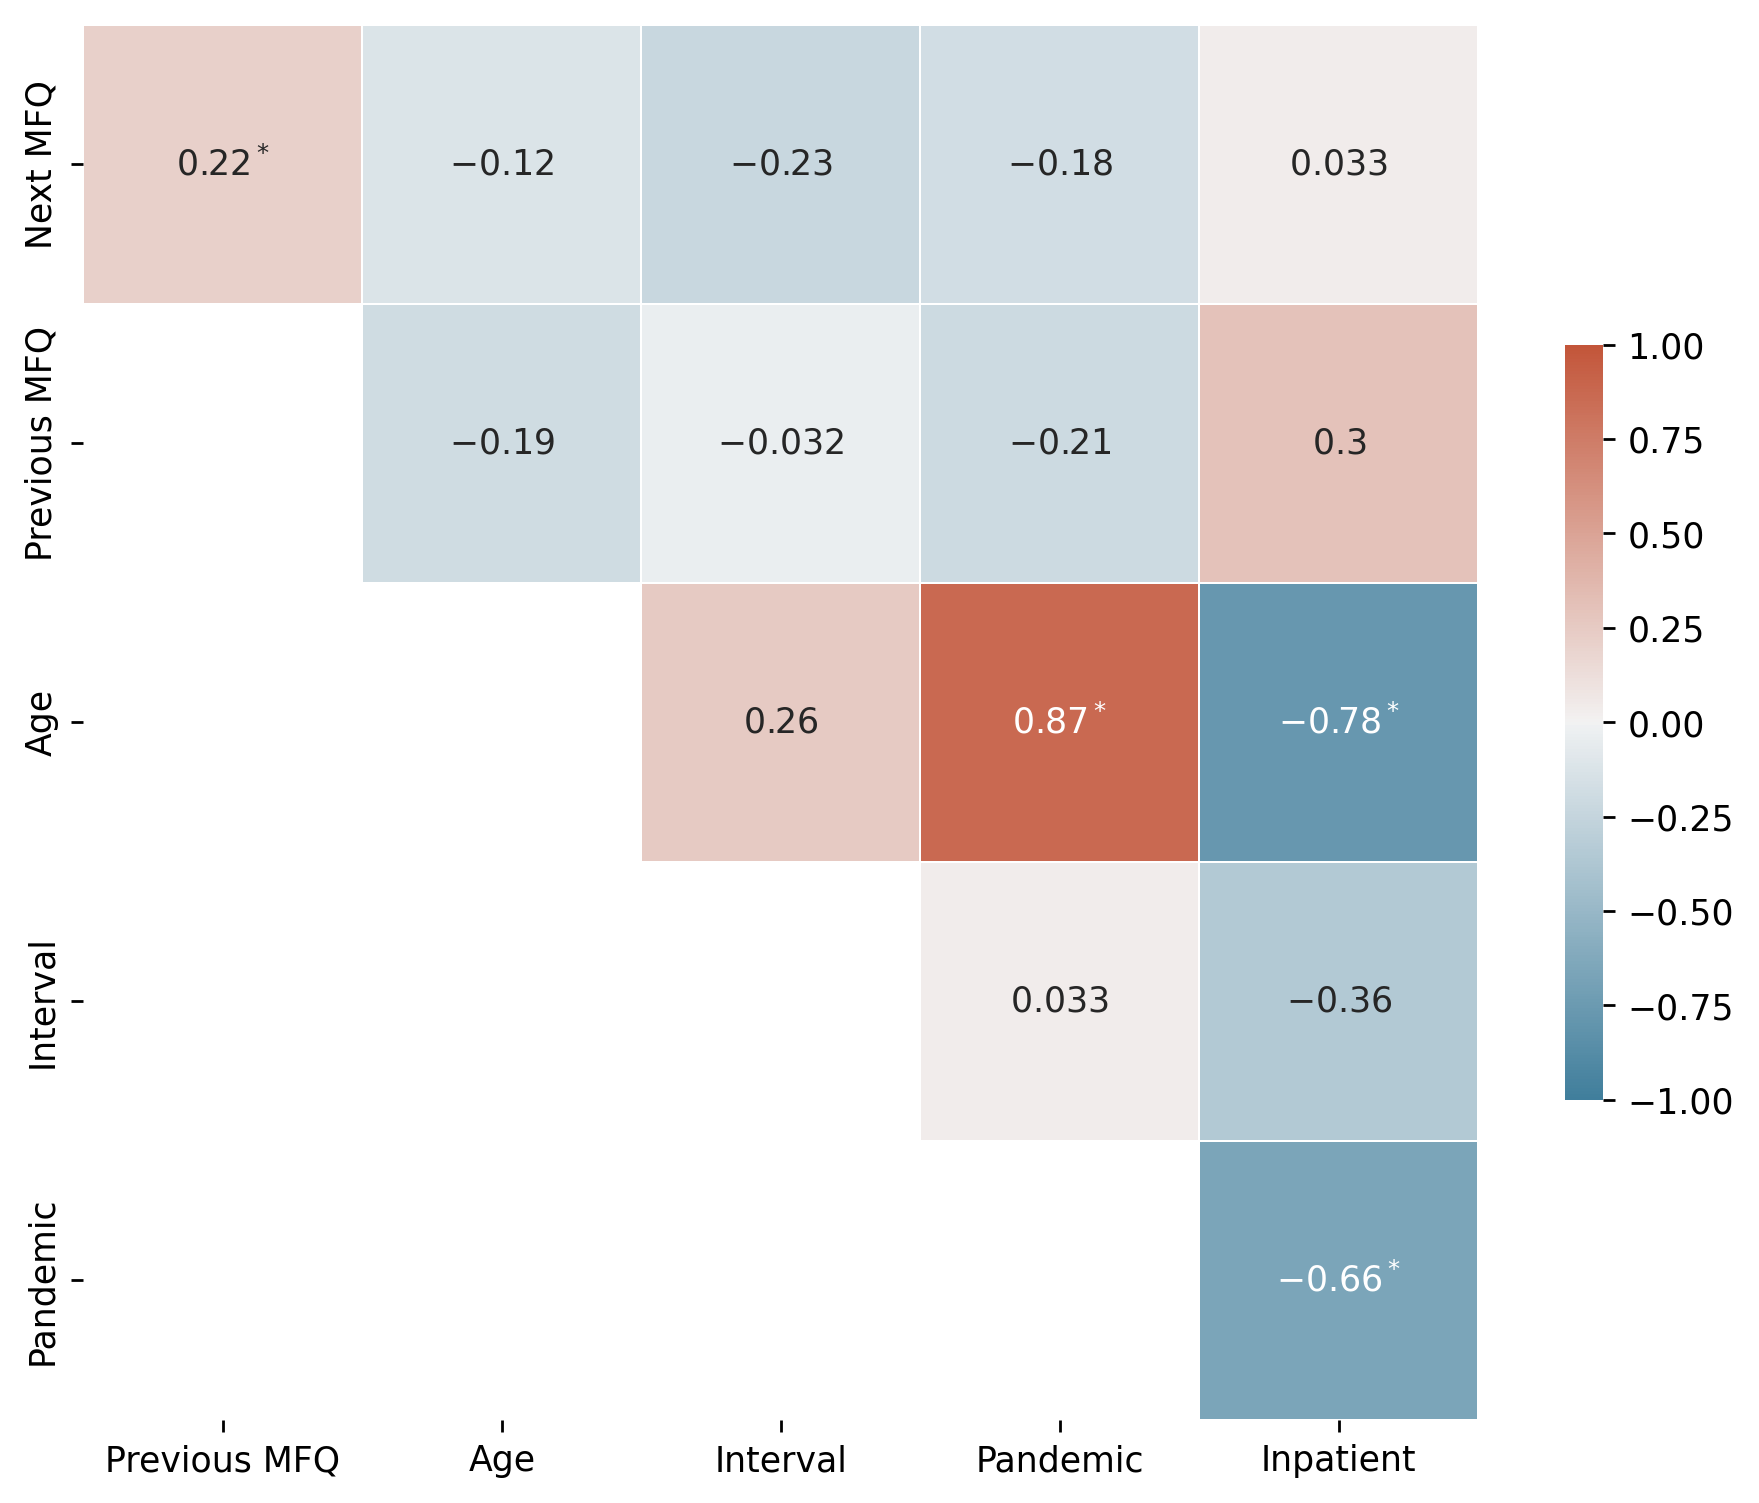

In [81]:
fig,ax = corr_plot(corr_visit, within_z, bonferoni_denomenator = mask_sub.sum() + mask_visit.sum(), cluster_var="SDAN")
fig.set_size_inches((9,8))

In [82]:
reses = []
for mix, model in models.items():
    ffs, rrs = kfold_lme(mdat, model, other_vars=['TimeBetween'])
    rrs['model'] = mix
    reses.append(rrs)
reses = pd.concat(reses)

Formula: s_mfq_tot~antidepressants+TimeBetween+InpatientDuring+Age_at_visit+SEX+OtherMeds+postpandemic+(TimeBetween|SDAN)

Family: gaussian	 Inference: parametric

Number of observations: 1146	 Groups: {'SDAN': 114.0}

Log-likelihood: -3462.957 	 AIC: 6925.914

Random effects:

                 Name     Var    Std
SDAN      (Intercept)  26.888  5.185
SDAN      TimeBetween  33.356  5.775
Residual               18.897  4.347

              IV1          IV2   Corr
SDAN  (Intercept)  TimeBetween -0.431

Fixed effects:

Formula: s_mfq_tot~antidepressants+TimeBetween+InpatientDuring+Age_at_visit+SEX+OtherMeds+postpandemic+(TimeBetween|SDAN)

Family: gaussian	 Inference: parametric

Number of observations: 1146	 Groups: {'SDAN': 113.0}

Log-likelihood: -3472.441 	 AIC: 6944.883

Random effects:

                 Name     Var    Std
SDAN      (Intercept)  23.438  4.841
SDAN      TimeBetween  35.811  5.984
Residual               19.550  4.422

              IV1          IV2   Corr
SDAN  (Interc

Formula: s_mfq_tot~antidepressants+TimeBetween*baseline_mfq+InpatientDuring+Age_at_visit+SEX+OtherMeds+postpandemic+(TimeBetween|SDAN)

Family: gaussian	 Inference: parametric

Number of observations: 1146	 Groups: {'SDAN': 114.0}

Log-likelihood: -3424.995 	 AIC: 6849.989

Random effects:

                 Name     Var    Std
SDAN      (Intercept)  14.956  3.867
SDAN      TimeBetween  36.847  6.070
Residual               18.775  4.333

              IV1          IV2  Corr
SDAN  (Intercept)  TimeBetween -0.66

Fixed effects:

Formula: s_mfq_tot~antidepressants+TimeBetween*baseline_mfq+InpatientDuring+Age_at_visit+SEX+OtherMeds+postpandemic+(TimeBetween|SDAN)

Family: gaussian	 Inference: parametric

Number of observations: 1146	 Groups: {'SDAN': 113.0}

Log-likelihood: -3441.558 	 AIC: 6883.117

Random effects:

                 Name     Var    Std
SDAN      (Intercept)  14.509  3.809
SDAN      TimeBetween  38.341  6.192
Residual               19.466  4.412

              IV1          

Formula: s_mfq_tot~antidepressants+TimeBetween*baseline_mfq+dep_immed+dep_immed:TimeBetween+InpatientDuring+Age_at_visit+SEX+OtherMeds+postpandemic+(TimeBetween|SDAN)

Family: gaussian	 Inference: parametric

Number of observations: 1147	 Groups: {'SDAN': 113.0}

Log-likelihood: -3394.286 	 AIC: 6788.571

Random effects:

                 Name     Var    Std
SDAN      (Intercept)  10.749  3.279
SDAN      TimeBetween  22.681  4.762
Residual               18.186  4.264

              IV1          IV2   Corr
SDAN  (Intercept)  TimeBetween -0.517

Fixed effects:

Formula: s_mfq_tot~antidepressants+TimeBetween+MFQtminus1+InpatientDuring+Age_at_visit+SEX+OtherMeds+postpandemic+(TimeBetween|SDAN)

Family: gaussian	 Inference: parametric

Number of observations: 1146	 Groups: {'SDAN': 114.0}

Log-likelihood: -3305.140 	 AIC: 6610.279

Random effects:

                 Name     Var    Std
SDAN      (Intercept)   3.339  1.827
SDAN      TimeBetween  10.394  3.224
Residual               16.970  4.

Formula: s_mfq_tot~dep_immed*TimeBetween+MFQtminus1+InpatientDuring+Age_at_visit+SEX+antidepressants+OtherMeds+postpandemic+(TimeBetween|SDAN)

Family: gaussian	 Inference: parametric

Number of observations: 1147	 Groups: {'SDAN': 113.0}

Log-likelihood: -3296.052 	 AIC: 6592.105

Random effects:

                 Name     Var    Std
SDAN      (Intercept)   3.540  1.881
SDAN      TimeBetween  12.274  3.503
Residual               16.316  4.039

              IV1          IV2   Corr
SDAN  (Intercept)  TimeBetween -0.337

Fixed effects:

Formula: s_mfq_tot~dep_immed*TimeBetween+dep_immed:Time2+Time2+MFQtminus1+InpatientDuring+Age_at_visit+SEX+antidepressants+OtherMeds+postpandemic+(TimeBetween|SDAN)

Family: gaussian	 Inference: parametric

Number of observations: 1146	 Groups: {'SDAN': 114.0}

Log-likelihood: -3297.784 	 AIC: 6595.568

Random effects:

                 Name     Var    Std
SDAN      (Intercept)   3.446  1.856
SDAN      TimeBetween  13.209  3.634
Residual               16

Formula: s_mfq_tot~antidepressants+TimeBetween*baseline_mfq+MFQtminus1+InpatientDuring+Age_at_visit+SEX+OtherMeds+postpandemic+(TimeBetween|SDAN)

Family: gaussian	 Inference: parametric

Number of observations: 1147	 Groups: {'SDAN': 113.0}

Log-likelihood: -3262.620 	 AIC: 6525.240

Random effects:

                 Name     Var    Std
SDAN      (Intercept)   2.276  1.509
SDAN      TimeBetween  23.441  4.842
Residual               15.833  3.979

              IV1          IV2   Corr
SDAN  (Intercept)  TimeBetween -0.824

Fixed effects:

Formula: s_mfq_tot~antidepressants+TimeBetween*baseline_mfq+MFQtminus1+InpatientDuring+Age_at_visit+SEX+OtherMeds+postpandemic+(TimeBetween|SDAN)

Family: gaussian	 Inference: parametric

Number of observations: 1147	 Groups: {'SDAN': 113.0}

Log-likelihood: -3267.212 	 AIC: 6534.425

Random effects:

                 Name     Var    Std
SDAN      (Intercept)   1.842  1.357
SDAN      TimeBetween  10.518  3.243
Residual               16.170  4.021

   

In [83]:
to_plot = reses.copy()
to_plot = to_plot.rename(
    columns={
        's_mfq_tot':'Actual MFQ Scores',
        's_mfq_tot_predicted':'Predicted MFQ Scores',
        'model': 'Model',
        'fold': 'Fold'
    })

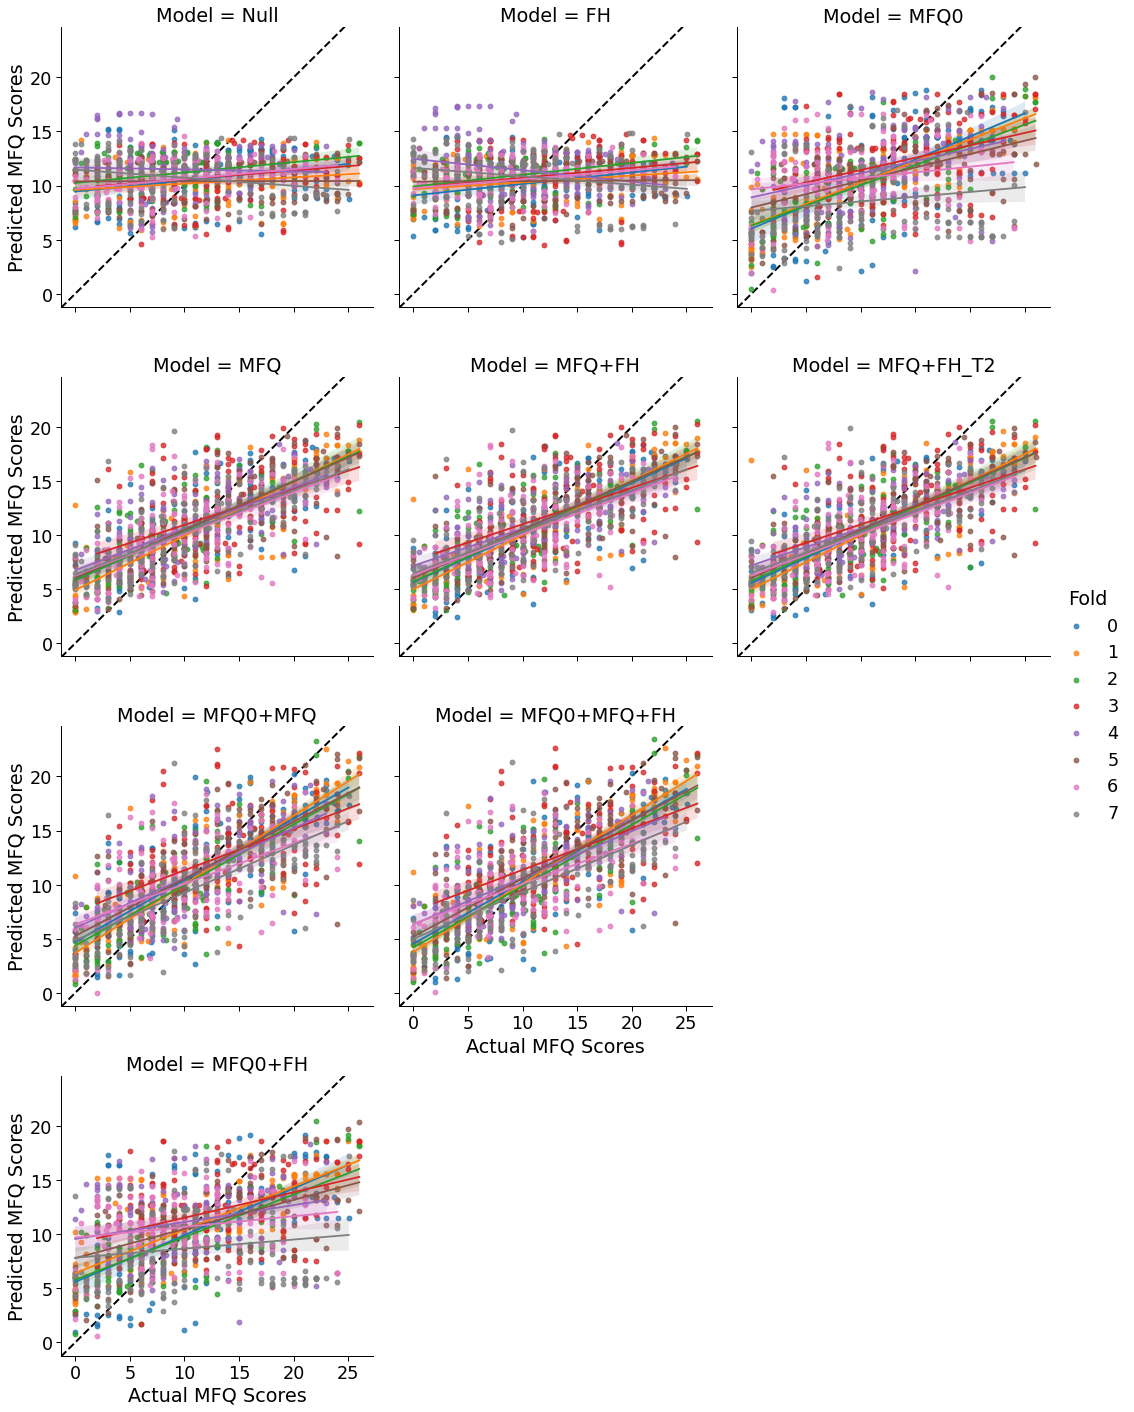

In [84]:
paper_rc = {'axes.facecolor':'white',
            'figure.facecolor':'white',
            'dpi': 250}
with sns.plotting_context("paper", font_scale=2, rc=paper_rc):
    g = sns.lmplot(x='Actual MFQ Scores', 
               y='Predicted MFQ Scores',
               data=to_plot,
               col='Model',
               col_wrap=3,
               col_order=['Null', 'FH', 'MFQ0', 'MFQ', 'MFQ+FH', 'MFQ+FH_T2', 'MFQ0+MFQ',  'MFQ0+MFQ+FH', 'no plot', 'MFQ0+FH'],
               hue='Fold',
               n_boot=10000)
    for ax in g.axes:
        ymin, ymax = ax.get_ylim()
        xmin, xmax = ax.get_xlim()
        ax.plot((xmin, xmax), (xmin, xmax),
                linestyle='dashed',
                color='black',
                linewidth=2,
                zorder=-1000)
        ax.set_ylim((ymin, ymax))
        ax.set_xlim((xmin, xmax))
    g.axes[8].set_visible(False)
#     g.fig.set_facecolor("white")

In [85]:
#reses.to_csv('../data/mfq_cv_predictions.csv', index=None)

In [86]:
var = 's_mfq_tot'
var_pred = var + '_predicted'

In [87]:
mf_agg = reses.groupby(['model', 'fold']).apply(lambda x: get_rsquared(var, x)).reset_index(name='r-squared')

In [88]:
reses['squared_error'] = (reses[var] - reses[var_pred]) ** 2
reses['residual'] = reses[var] - reses[var_pred]
reses['abs_error'] = np.abs(reses[var] - reses[var_pred])
mf_agg['rmse'] = np.sqrt(reses.groupby(['model', 'fold']).squared_error.mean()).reset_index(name='rmse').loc[:, ['rmse']]
# deal with grouping by subject
mf_agg['rmse_unweighted'] = np.sqrt(reses.groupby(['model', 'fold', 'SDAN']).squared_error.mean().reset_index(name='rmse_unweighted').drop('SDAN', axis=1).groupby(['model', 'fold']).mean()).loc[:, 'rmse_unweighted'].values

mf_agg['mae'] = reses.groupby(['model', 'fold']).abs_error.mean().reset_index(name='mae').loc[:, ['mae']]
mf_agg['mae_unweighted'] = reses.groupby(['model', 'fold', 'SDAN']).abs_error.mean().reset_index(name='mae_unweighted').drop('SDAN', axis=1).groupby(['model', 'fold']).mean().loc[:, 'mae_unweighted'].values


In [89]:
reses.head()

,SDAN,s_mfq_tot,TimeBetween,s_mfq_tot_predicted,fold,model,squared_error,residual,abs_error
61,23951,9.0,0.043836,15.174262,0,Null,38.121516,-6.174262,6.174262
62,23951,4.0,0.010959,15.210504,0,Null,125.675393,-11.210504,11.210504
63,23951,3.0,0.019178,15.188393,0,Null,148.556925,-12.188393,12.188393
64,23951,4.0,0.019178,15.176793,0,Null,124.920696,-11.176793,11.176793
65,23951,3.0,0.057534,15.092943,0,Null,146.239282,-12.092943,12.092943


In [90]:
to_plot = reses.copy()
to_plot = to_plot.rename(
    columns={
        'squared_error':'Squared Error',
        'residual': 'Residual',
        'TimeBetween':'Visit Interval (Months)',
        'model': 'Model',
        'fold': 'Fold'
    })
to_plot['Visit Interval (Months)'] = to_plot['Visit Interval (Months)']*365/30

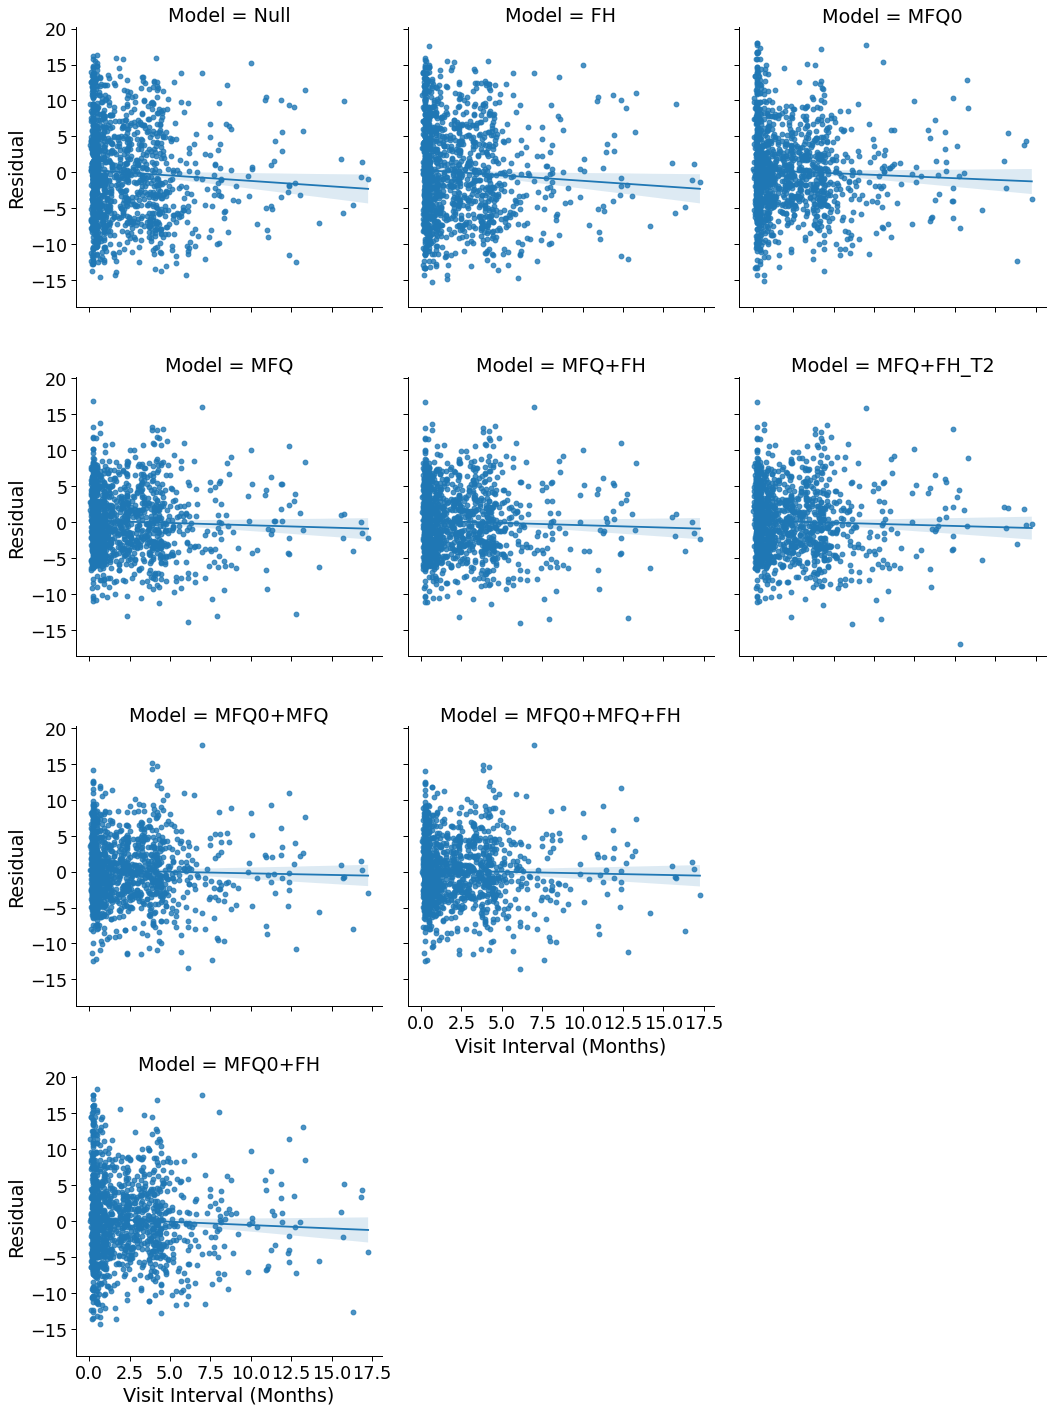

In [91]:
paper_rc = {'axes.facecolor':'white',
            'figure.facecolor':'white',
            'dpi': 250}
with sns.plotting_context("paper", font_scale=2, rc=paper_rc):
    g = sns.lmplot(x='Visit Interval (Months)', 
               y='Residual',
               data=to_plot,
               col='Model',
               col_wrap=3,
               col_order=['Null', 'FH', 'MFQ0', 'MFQ', 'MFQ+FH', 'MFQ+FH_T2', 'MFQ0+MFQ',  'MFQ0+MFQ+FH', 'no plot', 'MFQ0+FH'],
               #hue='Fold',
               n_boot=10000)
#    for ax in g.axes:
#        ax.set_xlim((0,1))
#     for ax in g.axes:
#         ymin, ymax = ax.get_ylim()
#         xmin, xmax = ax.get_xlim()
#         ax.plot((xmin, xmax), (xmin, xmax),
#                 linestyle='dashed',
#                 color='black',
#                 linewidth=2,
#                 zorder=-1000)
#         ax.set_ylim((ymin, ymax))
#         ax.set_xlim((xmin, xmax))
    g.axes[8].set_visible(False)
    g.fig.set_facecolor("white")

In [92]:
m_agg = mf_agg.groupby('model')[['rmse']].mean()
rmse_cis = mf_agg.groupby('model').apply(lambda x: get_999ci('rmse', x))
rmseuw = mf_agg.groupby('model')[['rmse_unweighted']].mean()
rmseuw_cis = mf_agg.groupby('model').apply(lambda x: get_999ci('rmse_unweighted', x))
mr2_agg = mf_agg.groupby('model')[['r-squared']].mean()
r2_cis = mf_agg.groupby('model').apply(lambda x: get_999ci('r-squared', x))

mae_agg = mf_agg.groupby('model')[['mae']].mean()
mae_cis = mf_agg.groupby('model').apply(lambda x: get_999ci('mae', x))
maeuw_agg = mf_agg.groupby('model')[['mae_unweighted']].mean()
maeuw_cis = mf_agg.groupby('model').apply(lambda x: get_999ci('mae_unweighted', x))

pd.concat([m_agg,
           rmse_cis.loc[:, ['rmse_lci', 'rmse_uci']],
           mr2_agg.loc[:, ['r-squared']],
           r2_cis.loc[:, ['r-squared_lci', 'r-squared_uci']],
           rmseuw.loc[:, ['rmse_unweighted']],
           rmseuw_cis.loc[:, ['rmse_unweighted_lci', 'rmse_unweighted_uci']],
           mae_agg.loc[:, ['mae']],
           mae_cis.loc[:, ['mae_lci', 'mae_uci']],
           maeuw_agg.loc[:, ['mae_unweighted']],
           maeuw_cis.loc[:, ['mae_unweighted_lci', 'mae_unweighted_uci']]
          ], axis=1)

,rmse,rmse_lci,rmse_uci,r-squared,r-squared_lci,r-squared_uci,rmse_unweighted,rmse_unweighted_lci,rmse_unweighted_uci,mae,mae_lci,mae_uci,mae_unweighted,mae_unweighted_lci,mae_unweighted_uci
model,,,,,,,,,,,,,,,
FH,6.586131,5.508983,7.716253,-0.113097,-0.412909,0.045837,6.632361,5.707768,7.801778,5.458182,4.604944,6.364620,5.526799,4.639486,6.599239
MFQ,4.532836,4.102577,4.995219,0.457584,0.243708,0.631868,4.695873,4.327509,5.116033,3.631913,3.254671,3.954502,3.782610,3.435327,4.139269
MFQ+FH,4.556431,4.075813,5.008725,0.451602,0.244010,0.630724,4.714522,4.321759,5.214972,3.661878,3.251575,4.010794,3.808581,3.435311,4.226345
MFQ+FH_T2,4.573044,4.111486,5.006640,0.448442,0.246250,0.619400,4.716104,4.294926,5.214017,3.663982,3.268631,4.015250,3.790346,3.345012,4.221098
MFQ0,5.655428,4.414817,7.168607,0.152856,-0.184619,0.493817,5.468032,4.425983,6.463028,4.448993,3.591173,5.422747,4.310861,3.571669,4.992437
MFQ0+FH,5.644576,4.305316,7.273737,0.153670,-0.195202,0.499803,5.453242,4.339483,6.546037,4.451116,3.479928,5.532390,4.321394,3.507879,5.118793
MFQ0+MFQ,4.320706,3.728263,4.911296,0.498295,0.266951,0.716840,4.478037,3.897550,5.160448,3.375966,2.880014,3.831910,3.499903,3.025640,4.064604
MFQ0+MFQ+FH,4.332020,3.719910,4.924318,0.495828,0.270730,0.715887,4.482967,3.889036,5.204404,3.394938,2.876048,3.891671,3.514953,3.032330,4.121597
Null,6.544357,5.533464,7.636184,-0.093727,-0.265403,0.026538,6.580638,5.731814,7.785250,5.419855,4.639291,6.324060,5.471041,4.642713,6.580704


In [93]:
mfq_pw_res_path = Path('../data/mfq_pairwise_res.csv')
if not mfq_pw_res_path.exists():
    df = mf_agg.copy()
    metrics = ['rmse', 'mae', 'rmse_unweighted', 'mae_unweighted']
    res = []
    folds = df.fold.unique()
    bootstrap_folds = list(itertools.product(folds, repeat=len(folds)))
    bootstrap_folds = set([tuple(sorted(x)) for x in bootstrap_folds])
    for iix, inds in enumerate(bootstrap_folds):
        for bsfi, ix in enumerate(inds):
            for metric in metrics:
                row={}
                row['bsi'] = iix
                row['bsfold'] = bsfi
                row['metric'] = metric
                for model in model_names:
                    row[f'{model}'] = df.loc[(df.model == model) & (df.fold == ix), metric].values[0]
                res.append(row)
    pairwise_res = pd.DataFrame(res)
    pairwise_res.to_csv(mfq_pw_res_path, index=None)
else:
     pairwise_res = pd.read_csv(mfq_pw_res_path)    

In [94]:
model_pairs = list(itertools.combinations(model_names, 2))
diffs_of_interest = [
    ('Null', 'FH'),
    ('Null', 'MFQ'),
    ('Null', 'MFQ+FH'),
    ('Null', 'MFQ0'),
    ('Null', 'MFQ0+MFQ'),
    ('MFQ0', 'MFQ0+FH'),    
    ('MFQ0', 'MFQ'),
    ('MFQ', 'MFQ+FH'),
    ('MFQ', 'MFQ+FH_T2'),
    ('MFQ+FH', 'MFQ+FH_T2'),
    ('MFQ', 'MFQ0+MFQ'),
    ('MFQ', 'MFQ0+MFQ+FH'),
]
for mp in diffs_of_interest:
    print(f'{mp[0]} - {mp[1]}')

Null - FH
Null - MFQ
Null - MFQ+FH
Null - MFQ0
Null - MFQ0+MFQ
MFQ0 - MFQ0+FH
MFQ0 - MFQ
MFQ - MFQ+FH
MFQ - MFQ+FH_T2
MFQ+FH - MFQ+FH_T2
MFQ - MFQ0+MFQ
MFQ - MFQ0+MFQ+FH


In [95]:

len(diffs_of_interest)

12

In [96]:
0.05 / len(diffs_of_interest)

0.004166666666666667

In [97]:
for mp in diffs_of_interest:
    pairwise_res[f'{mp[0]} - {mp[1]}'] = pairwise_res[mp[0]] - pairwise_res[mp[1]]

In [98]:
to_plot = mf_agg
to_plot = to_plot.rename(columns = {
    'model': 'Model',
    'rmse': 'RMSE',
})


In [99]:
doi_names = [f'{dda} - {ddb}' for dda, ddb in diffs_of_interest]
to_plot = pairwise_res.query('metric == "rmse"').groupby('bsi').mean().loc[:, doi_names[::-1]]
to_plot_cis = to_plot.quantile([0.0005, 0.9995]).T
to_plot_means = to_plot.mean().T
to_plot_cis['meanval'] = to_plot_means
to_plot_cis = to_plot_cis.reset_index()
to_plot_cis[0.0005] = to_plot_cis.meanval - to_plot_cis[0.0005]
to_plot_cis[0.9995] = to_plot_cis[0.9995] - to_plot_cis.meanval

In [100]:
to_plot_mae = pairwise_res.query('metric == "mae"').groupby('bsi').mean().loc[:, doi_names[::-1]]
to_plot_mae_cis = to_plot_mae.quantile([0.0005, 0.9995]).T
to_plot_mae_means = to_plot_mae.mean().T
to_plot_mae_cis['meanval'] = to_plot_mae_means
to_plot_mae_cis = to_plot_mae_cis.reset_index()
to_plot_mae_cis[0.0005] = to_plot_mae_cis.meanval - to_plot_mae_cis[0.0005]
to_plot_mae_cis[0.9995] = to_plot_mae_cis[0.9995] - to_plot_mae_cis.meanval

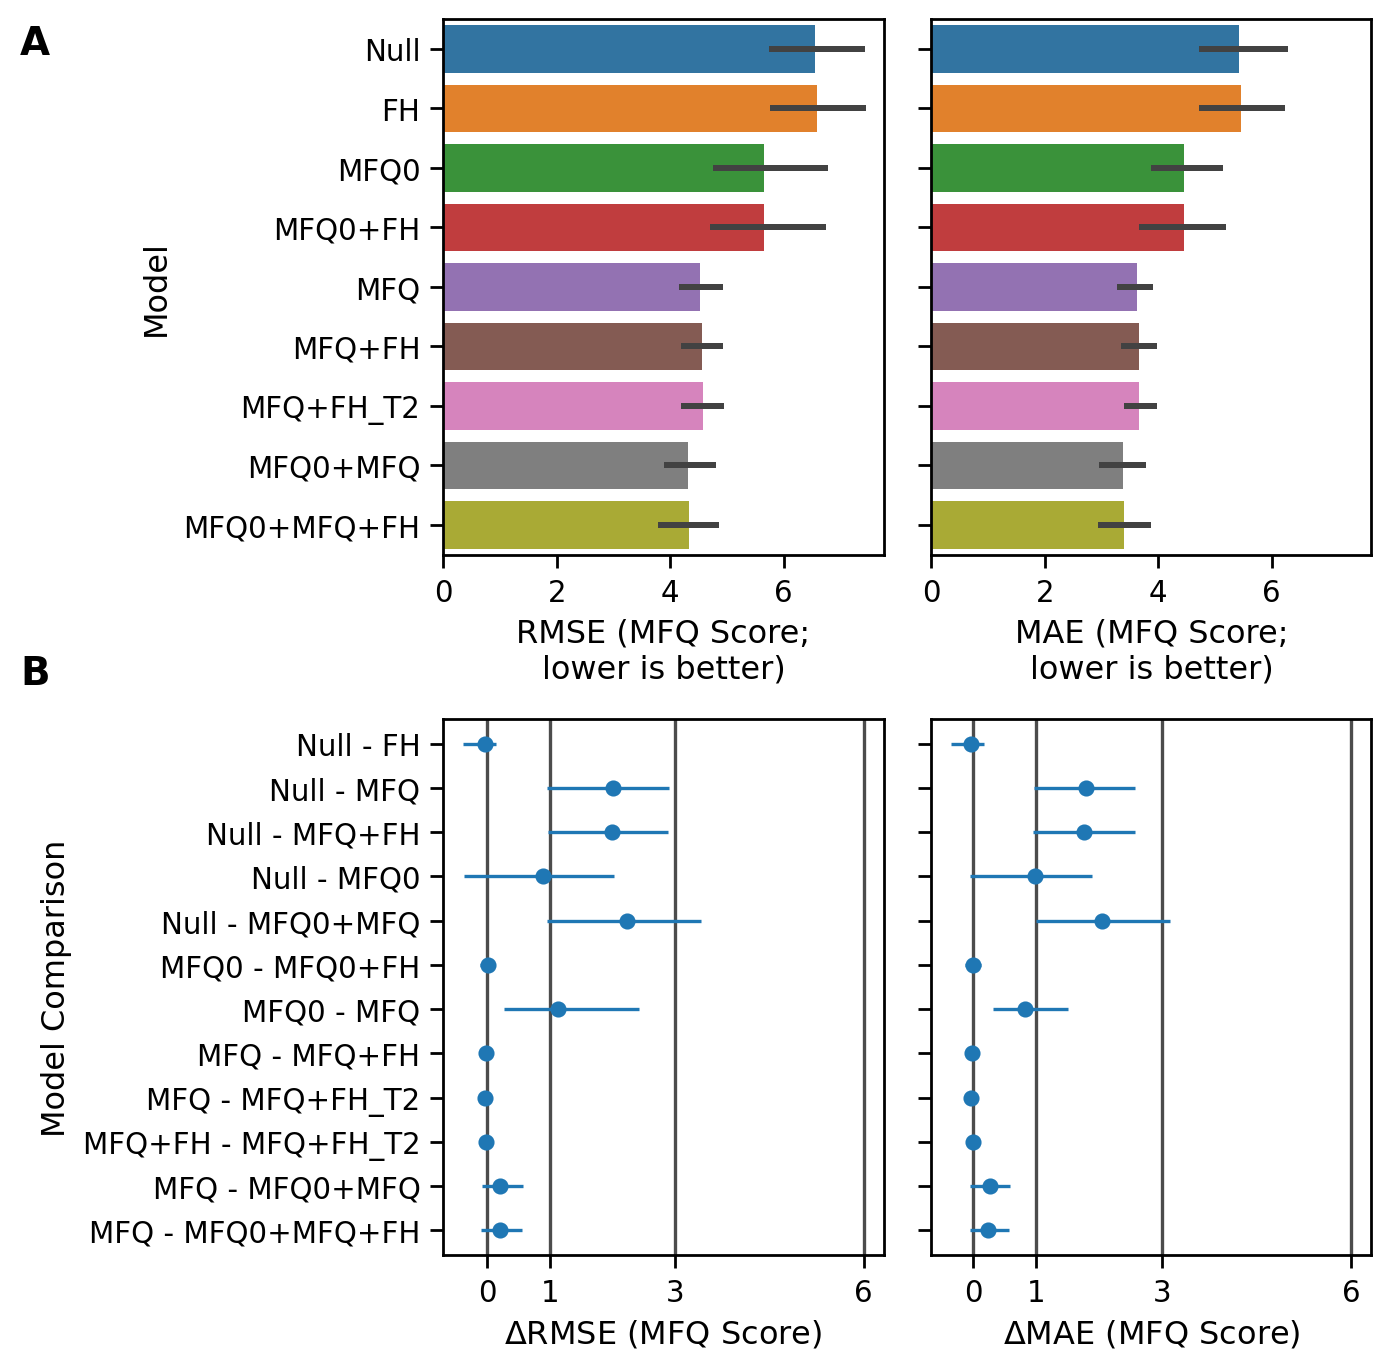

In [101]:
# supplement figure
to_plot_a = mf_agg
to_plot_a = to_plot_a.rename(columns = {
    'model': 'Model',
    'rmse': 'RMSE',
    'mae': 'MAE'
})

with sns.plotting_context("paper", font_scale=1.2, rc=paper_rc):

    fig, axes = plt.subplots(2,2, figsize=(7,7), sharex=False, dpi=200, 
                             gridspec_kw={'width_ratios': [1, 1]})
    ax = axes[0,0]
    ax = sns.barplot(y="Model", x='RMSE', data=to_plot_a, order=model_names, ci=99.9, ax=ax)
    ax.set_xlabel('RMSE (MFQ Score;\nlower is better)')
    ax.get_figure().set_facecolor("white")
    a_xmin, a_xmax = ax.get_xlim()
    
    ax = axes[1,0]
    ax.errorbar(x=to_plot_cis.meanval,
                xerr=to_plot_cis.loc[:, [0.0005, 0.9995]].T.values,
                y=to_plot_cis.index.values,
                fmt='o')
    ax.set_yticks(to_plot_cis.index.values)
    ax.set_yticklabels(to_plot_cis['index'].values)
    ymin, ymax = ax.get_ylim()
    ax.vlines([0, 1, 3, 6], ymin, ymax,colors='black', zorder=-10, alpha =0.7)
    ax.set_ylim((ymin, ymax))
    ax.set_ylabel('Model Comparison')
    ax.set_xticks([0,1,3,6])

    ax.set_xlabel('$\Delta$RMSE (MFQ Score)')
    b_xmin, b_xmax = ax.get_xlim()

    
    ax = axes[0,1]
    ax = sns.barplot(y="Model", x='MAE', data=to_plot_a, order=model_names, ci=99.9, ax=ax)
    ax.set_xlabel('MAE (MFQ Score;\nlower is better)')
    ax.get_figure().set_facecolor("white")
    ax.set_yticklabels([])
    ax.set_ylabel(None)
    ax.set_xlim((a_xmin, a_xmax))
    #ax.set_xlim((0, 9))
    #ax.set_xticks([0,5])

    ax = axes[1,1]
    ax.errorbar(x=to_plot_mae_cis.meanval,
                xerr=to_plot_mae_cis.loc[:, [0.0005, 0.9995]].T.values,
                y=to_plot_mae_cis.index.values,
                fmt='o')
    ax.set_yticks(to_plot_mae_cis.index.values)
    ax.set_yticklabels([])
    ymin, ymax = ax.get_ylim()
    ax.vlines([0, 1, 3, 6], ymin, ymax,colors='black', zorder=-10, alpha =0.7)
    ax.set_ylim((ymin, ymax))
    ax.set_xticks([0,1,3,6])

    ax.set_xlabel('$\Delta$MAE (MFQ Score)')
    #ax.set_xlim((-1.45, 1.45))

    fig.set_facecolor('white')
    fig.tight_layout()
    fig.text(0.01, 0.95, 'A', fontsize=14, fontweight='bold')
    fig.text(0.01, 0.5, 'B', fontsize=14, fontweight='bold')

In [129]:
# # supplemental figure
# to_plot_a = mf_agg
# to_plot_a = to_plot_a.rename(columns = {
#     'model': 'Model',
#     'rmse': 'RMSE',
#     'mae': 'MAE'
# })

# with sns.plotting_context("paper", font_scale=1.2, rc=paper_rc):

#     fig, axes = plt.subplots(2,1, figsize=(5,7), sharex=False)
#     ax = axes[0]
#     ax = sns.barplot(y="Model", x='RMSE', data=to_plot_a, order=model_names, ci=99.9, ax=ax)
#     ax.set_xlabel(None)
#     ax.get_figure().set_facecolor("white")
#     ax.set_xlabel('RMSE (MFQ Score; lower is better)')

#     ax = axes[1]
#     ax.errorbar(x=to_plot_cis.meanval,
#                 xerr=to_plot_cis.loc[:, [0.0005, 0.9995]].T.values,
#                 y=to_plot_cis.index.values,
#                 fmt='o')
#     ax.set_yticks(to_plot_cis.index.values)
#     ax.set_yticklabels(to_plot_cis['index'].values)
#     ymin, ymax = ax.get_ylim()
#     ax.vlines([0, 1, 3,6], ymin, ymax,colors='black', zorder=-10, alpha =0.7)
#     ax.set_ylim((ymin, ymax))
#     ax.set_xlabel('$\Delta$RMSE (MFQ Score)')
#     ax.set_ylabel('Model Comparison')
#     ax.set_xticks([0,1,3,6])
#     ax.set_xticklabels([0,1,3,6])
#     fig.set_facecolor('white')
#     fig.tight_layout()
#     fig.text(0.01, 0.95, 'A', fontsize=14, fontweight='bold')
#     fig.text(0.01, 0.5, 'B', fontsize=14, fontweight='bold')

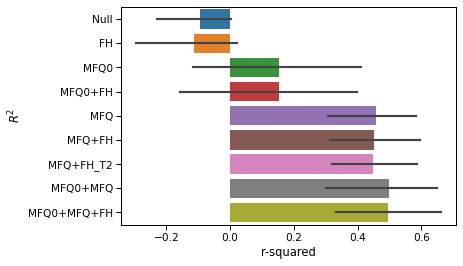

In [102]:
with sns.plotting_context("paper", font_scale=1.2, rc=paper_rc):
    ax = sns.barplot(y="Model", x='r-squared', data=to_plot_a, order=model_names, ci=99.9)
    ax.set_ylabel('$R^2$')
    ax.get_figure().set_facecolor("white")

# Calculate differences

In [103]:
pairwise_res.metric.unique()

array(['rmse', 'mae', 'rmse_unweighted', 'mae_unweighted'], dtype=object)

In [104]:
pairwise_res_mean = pairwise_res.query("metric == 'rmse'").groupby('bsi').mean()

### Does family history improve anything more than 1

In [105]:
difs = [
    'Null - FH',
    'MFQ0 - MFQ0+FH',
    'MFQ - MFQ+FH',
]
value = 1
difs


['Null - FH', 'MFQ0 - MFQ0+FH', 'MFQ - MFQ+FH']

In [106]:
mfq_fh_improve_test = (((pairwise_res_mean.loc[:, difs].max(1) > value).sum())) / len(pairwise_res_mean)
mfq_fh_improve_test

0.0

### Do any models have an RMSE greater than 8 or less than 3

In [107]:
value_a = 8
value_b = 3
model_names

['Null',
 'FH',
 'MFQ0',
 'MFQ0+FH',
 'MFQ',
 'MFQ+FH',
 'MFQ+FH_T2',
 'MFQ0+MFQ',
 'MFQ0+MFQ+FH']

In [108]:
test_ind = (
    (pairwise_res_mean.loc[:, difs].max(1) > value_a) 
    | (pairwise_res_mean.loc[:, difs].min(1) > value_b)
)

In [109]:
model_within_3_8 = (test_ind.sum()) / len(pairwise_res_mean)
model_within_3_8

0.0

### Does the quadratic model improve anything by more than 1?

In [110]:
difs = [
    ('MFQ - MFQ+FH_T2'),
    ('MFQ+FH - MFQ+FH_T2'),
]
value = 1
difs


['MFQ - MFQ+FH_T2', 'MFQ+FH - MFQ+FH_T2']

In [111]:
mfq_fh_improve_test = (((pairwise_res_mean.loc[:, difs].max(1) > value).sum())) / len(pairwise_res_mean)
mfq_fh_improve_test

0.0

In [117]:
# main_models = ['Null', 'FH', 'MFQ', 'MFQ+FH']
# to_plot_a = to_plot_a.loc[to_plot_a.Model.isin(main_models)]
# main_difs = ['MFQ - MFQ+FH', 'Null - MFQ+FH', 'Null - MFQ', 'Null - FH']
# to_plot_cis = to_plot_cis[to_plot_cis['index'].isin(main_difs)].reset_index(drop=True)
# to_plot_mae_cis = to_plot_mae_cis[to_plot_mae_cis['index'].isin(main_difs)].reset_index(drop=True)

# with sns.plotting_context("paper", font_scale=1.2, rc=paper_rc):

#     fig, axes = plt.subplots(2,2, figsize=(7,7), sharex=False, dpi=200, 
#                              gridspec_kw={'width_ratios': [1, 1]})
#     ax = axes[0,0]
#     ax = sns.barplot(y="Model", x='RMSE', data=to_plot_a, order=main_models, ci=99.9, ax=ax)
#     ax.set_xlabel('RMSE (MFQ Score;\nlower is better)')
#     ax.get_figure().set_facecolor("white")
#     a_xmin, a_xmax = ax.get_xlim()
    
#     ax = axes[1,0]
#     ax.errorbar(x=to_plot_cis.meanval,
#                 xerr=to_plot_cis.loc[:, [0.0005, 0.9995]].T.values,
#                 y=to_plot_cis.index.values,
#                 fmt='o')
#     ax.set_yticks(to_plot_cis.index.values)
#     ax.set_yticklabels(to_plot_cis['index'].values)
#     ymin, ymax = ax.get_ylim()
#     ax.vlines([0, 1, 3, 6], ymin, ymax,colors='black', zorder=-10, alpha =0.7)
#     ax.set_ylim((ymin, ymax))
#     ax.set_ylabel('Model Comparison')
#     ax.set_xticks([0,1,3,6])

#     ax.set_xlabel('$\Delta$RMSE (MFQ Score)')
#     b_xmin, b_xmax = ax.get_xlim()

    
#     ax = axes[0,1]
#     ax = sns.barplot(y="Model", x='MAE', data=to_plot_a, order=main_models, ci=99.9, ax=ax)
#     ax.set_xlabel('MAE (MFQ Score;\nlower is better)')
#     ax.get_figure().set_facecolor("white")
#     ax.set_yticklabels([])
#     ax.set_ylabel(None)
#     ax.set_xlim((a_xmin, a_xmax))
#     #ax.set_xlim((0, 9))
#     #ax.set_xticks([0,5])

#     ax = axes[1,1]
#     ax.errorbar(x=to_plot_mae_cis.meanval,
#                 xerr=to_plot_mae_cis.loc[:, [0.0005, 0.9995]].T.values,
#                 y=to_plot_mae_cis.index.values,
#                 fmt='o')
#     ax.set_yticks(to_plot_mae_cis.index.values)
#     ax.set_yticklabels([])
#     ymin, ymax = ax.get_ylim()
#     ax.vlines([0, 1, 3, 6], ymin, ymax,colors='black', zorder=-10, alpha =0.7)
#     ax.set_ylim((ymin, ymax))
#     ax.set_xticks([0,1,3,6])

#     ax.set_xlabel('$\Delta$MAE (MFQ Score)')
#     #ax.set_xlim((-1.45, 1.45))

#     fig.set_facecolor('white')
#     fig.tight_layout()
#     fig.text(0.01, 0.95, 'A', fontsize=14, fontweight='bold')
#     fig.text(0.01, 0.5, 'B', fontsize=14, fontweight='bold')

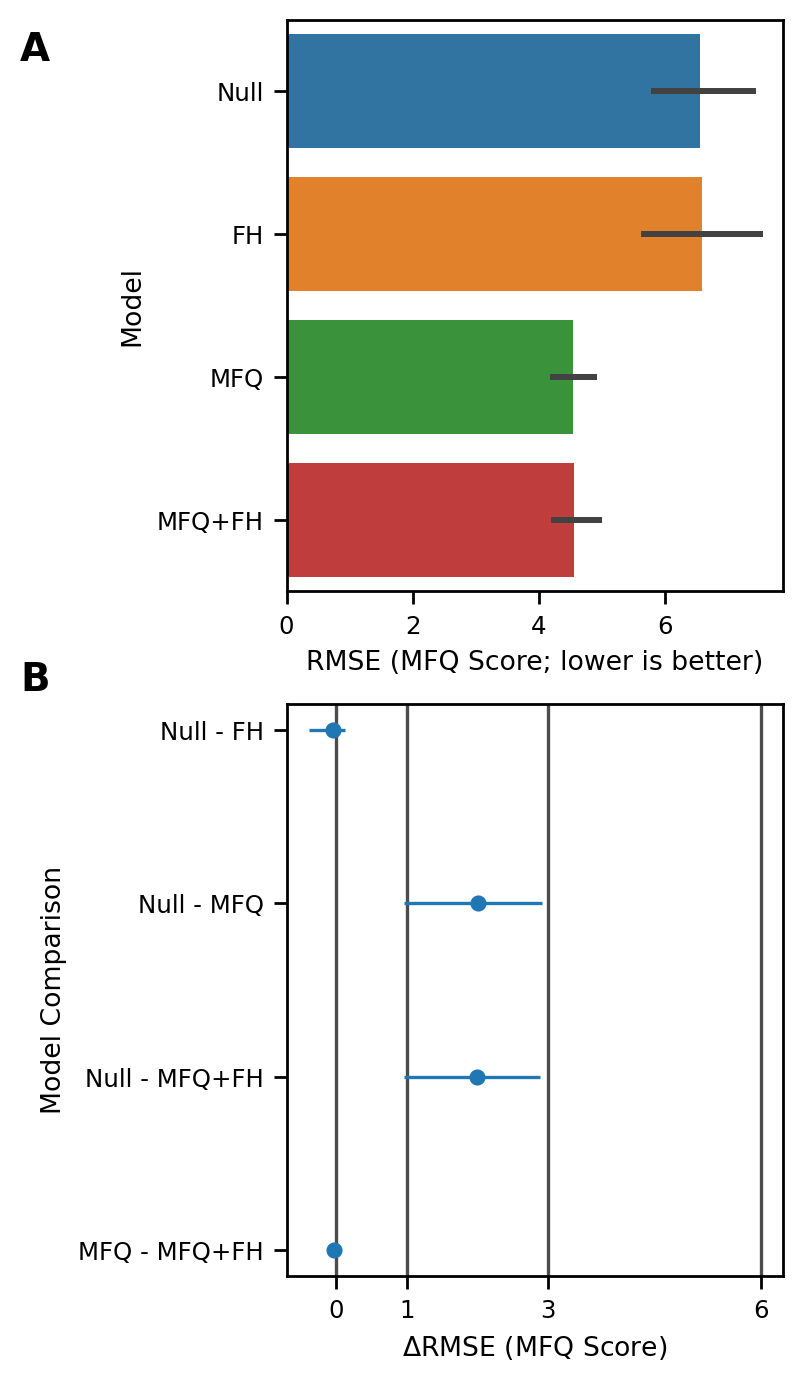

In [116]:
# main figure
main_models = ['Null', 'FH', 'MFQ', 'MFQ+FH']
to_plot_a = to_plot_a.loc[to_plot_a.Model.isin(main_models)]
main_difs = ['MFQ - MFQ+FH', 'Null - MFQ+FH', 'Null - MFQ', 'Null - FH']
to_plot_cis = to_plot_cis[to_plot_cis['index'].isin(main_difs)].reset_index(drop=True)

with sns.plotting_context("paper", rc=paper_rc):

    fig, axes = plt.subplots(2,1, figsize=(4,7), sharex=False, dpi=200)
    ax = axes[0]
    ax = sns.barplot(y="Model", x='RMSE', data=to_plot_a, order=main_models, ci=99.9, ax=ax)
    ax.set_xlabel(None)
    ax.get_figure().set_facecolor("white")
    ax.set_xlabel('RMSE (MFQ Score; lower is better)')

    ax = axes[1]
    ax.errorbar(x=to_plot_cis.meanval,
                xerr=to_plot_cis.loc[:, [0.0005, 0.9995]].T.values,
                y=to_plot_cis.index.values,
                fmt='o')
    ax.set_yticks(to_plot_cis.index.values)
    ax.set_yticklabels(to_plot_cis['index'].values)
    ymin, ymax = ax.get_ylim()
    ax.vlines([0, 1, 3, 6], ymin, ymax,colors='black', zorder=-10, alpha =0.7)
    ax.set_ylim((ymin, ymax))
    ax.set_xlabel('$\Delta$RMSE (MFQ Score)')
    ax.set_ylabel('Model Comparison')
    ax.set_xticks([0,1,3, 6])
    ax.set_xticklabels([0,1,3, 6])
    fig.set_facecolor('white')
    fig.tight_layout()
    fig.text(0.01, 0.95, 'A', fontsize=14, fontweight='bold')
    fig.text(0.01, 0.5, 'B', fontsize=14, fontweight='bold')
fig.savefig('mfq_main.pdf')

### Try using unweighted RMSE as well

In [118]:
to_plot = mf_agg
to_plot = to_plot.rename(columns = {
    'model': 'Model',
    'rmse_unweighted': 'Unweighted RMSE',
    'mae_unweighted': 'Unweighted MAE'
})


In [119]:
doi_names = [f'{dda} - {ddb}' for dda, ddb in diffs_of_interest]
to_plot = pairwise_res.query("metric == 'rmse_unweighted'").groupby('bsi').mean().loc[:, doi_names[::-1]]
to_plot_cis = to_plot.quantile([0.0005, 0.9995]).T
to_plot_means = to_plot.mean().T
to_plot_cis['meanval'] = to_plot_means
to_plot_cis = to_plot_cis.reset_index()
to_plot_cis[0.0005] = to_plot_cis.meanval - to_plot_cis[0.0005]
to_plot_cis[0.9995] = to_plot_cis[0.9995] - to_plot_cis.meanval

to_plot_mae = pairwise_res.query("metric == 'mae_unweighted'").groupby('bsi').mean().loc[:, doi_names[::-1]]
to_plot_mae_cis = to_plot_mae.quantile([0.0005, 0.9995]).T
to_plot_mae_means = to_plot_mae.mean().T
to_plot_mae_cis['meanval'] = to_plot_mae_means
to_plot_mae_cis = to_plot_mae_cis.reset_index()
to_plot_mae_cis[0.0005] = to_plot_mae_cis.meanval - to_plot_mae_cis[0.0005]
to_plot_mae_cis[0.9995] = to_plot_mae_cis[0.9995] - to_plot_mae_cis.meanval

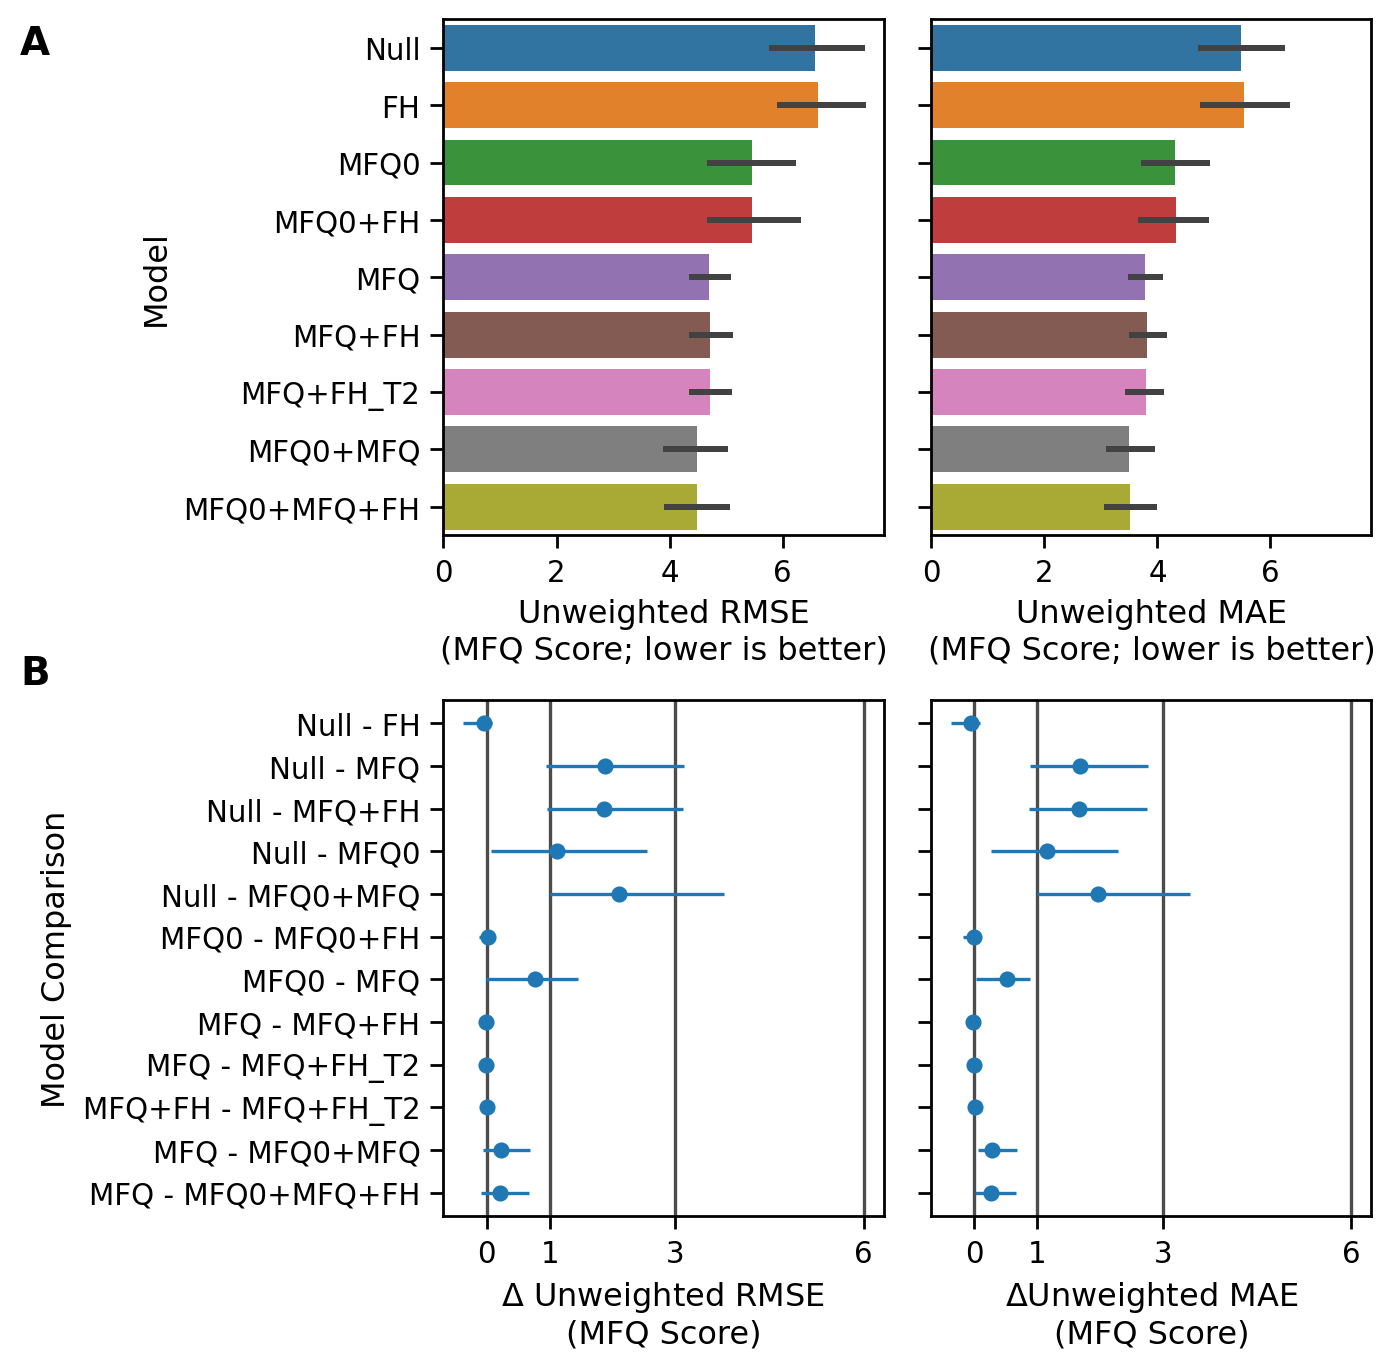

In [120]:
# supplement figure
to_plot_a = mf_agg
to_plot_a = to_plot_a.rename(columns = {
    'model': 'Model',
    'rmse_unweighted': 'Unweighted RMSE',
    'mae_unweighted': 'Unweighted MAE'
})

with sns.plotting_context("paper", font_scale=1.2, rc=paper_rc):

    fig, axes = plt.subplots(2,2, figsize=(7,7), sharex=False, dpi=200, 
                             gridspec_kw={'width_ratios': [1, 1]})
    ax = axes[0,0]
    ax = sns.barplot(y="Model", x='Unweighted RMSE', data=to_plot_a, order=model_names, ci=99.9, ax=ax)
    ax.set_xlabel('Unweighted RMSE\n(MFQ Score; lower is better)')
    ax.get_figure().set_facecolor("white")
    a_xmin, a_xmax = ax.get_xlim()
    
    ax = axes[1,0]
    ax.errorbar(x=to_plot_cis.meanval,
                xerr=to_plot_cis.loc[:, [0.0005, 0.9995]].T.values,
                y=to_plot_cis.index.values,
                fmt='o')
    ax.set_yticks(to_plot_cis.index.values)
    ax.set_yticklabels(to_plot_cis['index'].values)
    ymin, ymax = ax.get_ylim()
    ax.vlines([0, 1, 3, 6], ymin, ymax,colors='black', zorder=-10, alpha =0.7)
    ax.set_ylim((ymin, ymax))
    ax.set_ylabel('Model Comparison')
    ax.set_xticks([0,1,3,6])

    ax.set_xlabel('$\Delta$ Unweighted RMSE\n(MFQ Score)')
    b_xmin, b_xmax = ax.get_xlim()

    
    ax = axes[0,1]
    ax = sns.barplot(y="Model", x='Unweighted MAE', data=to_plot_a, order=model_names, ci=99.9, ax=ax)
    ax.set_xlabel('Unweighted MAE\n(MFQ Score; lower is better)')
    ax.get_figure().set_facecolor("white")
    ax.set_yticklabels([])
    ax.set_ylabel(None)
    ax.set_xlim((a_xmin, a_xmax))
    #ax.set_xlim((0, 9))
    #ax.set_xticks([0,5])

    ax = axes[1,1]
    ax.errorbar(x=to_plot_mae_cis.meanval,
                xerr=to_plot_mae_cis.loc[:, [0.0005, 0.9995]].T.values,
                y=to_plot_mae_cis.index.values,
                fmt='o')
    ax.set_yticks(to_plot_mae_cis.index.values)
    ax.set_yticklabels([])
    ymin, ymax = ax.get_ylim()
    ax.vlines([0, 1, 3, 6], ymin, ymax,colors='black', zorder=-10, alpha =0.7)
    ax.set_ylim((ymin, ymax))
    ax.set_xticks([0,1,3,6])

    ax.set_xlabel('$\Delta$Unweighted MAE\n(MFQ Score)')
    #ax.set_xlim((-1.45, 1.45))

    fig.set_facecolor('white')
    fig.tight_layout()
    fig.text(0.01, 0.95, 'A', fontsize=14, fontweight='bold')
    fig.text(0.01, 0.5, 'B', fontsize=14, fontweight='bold')

In [121]:
# # supplemental figure
# to_plot_a = mf_agg
# to_plot_a = to_plot_a.rename(columns = {
#     'model': 'Model',
#     'rmse_unweighted': 'Unweighted RMSE',
# })

# with sns.plotting_context("paper", font_scale=1.2, rc=paper_rc):

#     fig, axes = plt.subplots(2,1, figsize=(5,7), sharex=False)
#     ax = axes[0]
#     ax = sns.barplot(y="Model", x='Unweighted RMSE', data=to_plot_a, order=model_names, ci=99.9, ax=ax)
#     ax.set_xlabel(None)
#     ax.get_figure().set_facecolor("white")
#     ax.set_xlabel('Unweighted RMSE (MFQ Score; lower is better)')

#     ax = axes[1]
#     ax.errorbar(x=to_plot_cis.meanval,
#                 xerr=to_plot_cis.loc[:, [0.0005, 0.9995]].T.values,
#                 y=to_plot_cis.index.values,
#                 fmt='o')
#     ax.set_yticks(to_plot_cis.index.values)
#     ax.set_yticklabels(to_plot_cis['index'].values)
#     ymin, ymax = ax.get_ylim()
#     ax.vlines([0, 1, 3, 6], ymin, ymax,colors='black', zorder=-10, alpha =0.7)
#     ax.set_ylim((ymin, ymax))
#     ax.set_xlabel('$\Delta$Unweighted RMSE (MFQ)')
#     ax.set_ylabel('Model Comparison')
#     ax.set_xticks([0,1,3, 6])
#     ax.set_xticklabels([0,1,3, 6])
#     fig.set_facecolor('white')
#     fig.tight_layout()
#     fig.text(0.01, 0.95, 'A', fontsize=14, fontweight='bold')
#     fig.text(0.01, 0.5, 'B', fontsize=14, fontweight='bold')

In [122]:
pairwise_res_mean = pairwise_res.query("metric == 'rmse_unweighted'").groupby('bsi').mean()

In [123]:
difs = [
    'Null - FH',
    'MFQ0 - MFQ0+FH',
    'MFQ - MFQ+FH',
]
value = 1
difs


['Null - FH', 'MFQ0 - MFQ0+FH', 'MFQ - MFQ+FH']

In [124]:
mfq_fh_improve_test = (((pairwise_res_mean.loc[:, difs].max(1) > value).sum())) / len(pairwise_res_mean)
mfq_fh_improve_test

0.0

In [125]:
value_a = 8
value_b = 3
model_names

['Null',
 'FH',
 'MFQ0',
 'MFQ0+FH',
 'MFQ',
 'MFQ+FH',
 'MFQ+FH_T2',
 'MFQ0+MFQ',
 'MFQ0+MFQ+FH']

In [126]:
test_ind = (
    (pairwise_res_mean.loc[:, difs].max(1) > value_a) 
    | (pairwise_res_mean.loc[:, difs].min(1) > value_b)
)

In [127]:
model_within_3_8 = (test_ind.sum()) / len(pairwise_res_mean)
model_within_3_8

0.0

In [128]:
difs = [
    ('MFQ - MFQ+FH_T2'),
    ('MFQ+FH - MFQ+FH_T2'),
]
value = 1
difs


['MFQ - MFQ+FH_T2', 'MFQ+FH - MFQ+FH_T2']

In [129]:
mfq_fh_improve_test = (((pairwise_res_mean.loc[:, difs].max(1) > value).sum())) / len(pairwise_res_mean)
mfq_fh_improve_test

0.0

In [130]:
reses.to_csv('../data/mfq_cv_predictions.csv', index=None)

In [131]:
## fit models to everything
model_name = list(models.keys())[0]
print(f"Fitting {model_name} Model to all data, don't use these fit statistics.")
model = models[model_name]
mdl = Lmer(model, mdat)
mdl.fit()


Fitting Null Model to all data, don't use these fit statistics.
Formula: s_mfq_tot~antidepressants+TimeBetween+InpatientDuring+Age_at_visit+SEX+OtherMeds+postpandemic+(TimeBetween|SDAN)

Family: gaussian	 Inference: parametric

Number of observations: 1310	 Groups: {'SDAN': 129.0}

Log-likelihood: -3954.559 	 AIC: 7909.118

Random effects:

                 Name     Var    Std
SDAN      (Intercept)  25.345  5.034
SDAN      TimeBetween  32.823  5.729
Residual               18.783  4.334

              IV1          IV2  Corr
SDAN  (Intercept)  TimeBetween -0.37

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,DF,T-stat,P-val,Sig
(Intercept),21.839,15.395,28.284,3.288,306.286,6.642,0.000,***
antidepressants,-0.054,-2.088,1.980,1.038,115.000,-0.052,0.959,
TimeBetween,-1.158,-2.911,0.596,0.895,79.023,-1.294,0.199,
InpatientDuring,-0.319,-1.354,0.717,0.528,1168.456,-0.603,0.546,
Age_at_visit,-0.559,-0.965,-0.153,0.207,305.494,-2.699,0.007,**
SEX,-3.382,-5.408,-1.357,1.033,115.720,-3.273,0.001,**
OtherMeds,0.614,-1.660,2.887,1.160,113.623,0.529,0.598,
postpandemic,-1.062,-1.907,-0.217,0.431,813.801,-2.463,0.014,*


In [132]:
## fit models to everything
model_name = list(models.keys())[1]
print(f"Fitting {model_name} Model to all data, don't use these fit statistics.")
model = models[model_name]
mdl = Lmer(model, mdat)
mdl.fit()


Fitting FH Model to all data, don't use these fit statistics.
Formula: s_mfq_tot~dep_immed*TimeBetween+InpatientDuring+Age_at_visit+SEX+antidepressants+OtherMeds+postpandemic+(TimeBetween|SDAN)

Family: gaussian	 Inference: parametric

Number of observations: 1310	 Groups: {'SDAN': 129.0}

Log-likelihood: -3951.287 	 AIC: 7902.574

Random effects:

                 Name     Var    Std
SDAN      (Intercept)  25.157  5.016
SDAN      TimeBetween  33.851  5.818
Residual               18.780  4.334

              IV1          IV2   Corr
SDAN  (Intercept)  TimeBetween -0.366

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,DF,T-stat,P-val,Sig
(Intercept),21.067,14.490,27.645,3.356,284.374,6.278,0.000,***
dep_immed,1.296,-0.916,3.508,1.129,110.333,1.149,0.253,
TimeBetween,-0.882,-4.342,2.578,1.765,76.987,-0.500,0.619,
InpatientDuring,-0.322,-1.358,0.714,0.529,1168.163,-0.609,0.543,
Age_at_visit,-0.570,-0.975,-0.164,0.207,302.166,-2.753,0.006,**
SEX,-3.295,-5.320,-1.270,1.033,114.158,-3.189,0.002,**
antidepressants,-0.110,-2.140,1.920,1.036,113.632,-0.106,0.916,
OtherMeds,0.606,-1.662,2.873,1.157,112.262,0.523,0.602,
postpandemic,-1.046,-1.892,-0.200,0.432,809.301,-2.424,0.016,*
dep_immed:TimeBetween,-0.384,-4.350,3.583,2.024,73.455,-0.190,0.850,


In [133]:
## fit models to everything
model_name = list(models.keys())[2]
print(f"Fitting {model_name} Model to all data, don't use these fit statistics.")
model = models[model_name]
mdl = Lmer(model, mdat)
mdl.fit()


Fitting MFQ0 Model to all data, don't use these fit statistics.
Formula: s_mfq_tot~antidepressants+TimeBetween*baseline_mfq+InpatientDuring+Age_at_visit+SEX+OtherMeds+postpandemic+(TimeBetween|SDAN)

Family: gaussian	 Inference: parametric

Number of observations: 1310	 Groups: {'SDAN': 129.0}

Log-likelihood: -3908.891 	 AIC: 7817.781

Random effects:

                 Name     Var    Std
SDAN      (Intercept)  14.203  3.769
SDAN      TimeBetween  35.345  5.945
Residual               18.653  4.319

              IV1          IV2  Corr
SDAN  (Intercept)  TimeBetween -0.66

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,DF,T-stat,P-val,Sig
(Intercept),10.944,5.513,16.376,2.771,223.324,3.950,0.000,***
antidepressants,-0.003,-1.392,1.386,0.709,111.517,-0.004,0.997,
TimeBetween,-4.511,-7.811,-1.212,1.684,87.491,-2.680,0.009,**
baseline_mfq,0.509,0.381,0.636,0.065,137.556,7.815,0.000,***
InpatientDuring,-0.182,-1.200,0.837,0.520,1224.119,-0.350,0.727,
Age_at_visit,-0.225,-0.544,0.094,0.163,210.899,-1.385,0.168,
SEX,-1.388,-2.808,0.032,0.724,111.047,-1.916,0.058,.
OtherMeds,-0.222,-1.775,1.332,0.793,109.510,-0.280,0.780,
postpandemic,-1.458,-2.214,-0.703,0.385,836.871,-3.786,0.000,***
TimeBetween:baseline_mfq,0.307,0.020,0.593,0.146,87.820,2.096,0.039,*


In [134]:
## fit models to everything
model_name = list(models.keys())[3]
print(f"Fitting {model_name} Model to all data, don't use these fit statistics.")
model = models[model_name]
mdl = Lmer(model, mdat)
mdl.fit()


Fitting MFQ0+FH Model to all data, don't use these fit statistics.
Formula: s_mfq_tot~antidepressants+TimeBetween*baseline_mfq+dep_immed+dep_immed:TimeBetween+InpatientDuring+Age_at_visit+SEX+OtherMeds+postpandemic+(TimeBetween|SDAN)

Family: gaussian	 Inference: parametric

Number of observations: 1310	 Groups: {'SDAN': 129.0}

Log-likelihood: -3905.264 	 AIC: 7810.528

Random effects:

                 Name     Var    Std
SDAN      (Intercept)  14.006  3.743
SDAN      TimeBetween  36.344  6.029
Residual               18.645  4.318

              IV1          IV2  Corr
SDAN  (Intercept)  TimeBetween -0.66

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,DF,T-stat,P-val,Sig
(Intercept),10.312,4.808,15.817,2.808,217.747,3.672,0.000,***
antidepressants,-0.055,-1.435,1.325,0.704,110.857,-0.078,0.938,
TimeBetween,-4.346,-8.850,0.157,2.298,89.302,-1.892,0.062,.
baseline_mfq,0.506,0.379,0.633,0.065,136.814,7.806,0.000,***
dep_immed,1.273,-0.485,3.031,0.897,118.905,1.419,0.158,
InpatientDuring,-0.181,-1.200,0.837,0.520,1223.271,-0.349,0.727,
Age_at_visit,-0.241,-0.559,0.077,0.162,210.170,-1.486,0.139,
SEX,-1.333,-2.746,0.079,0.721,110.176,-1.851,0.067,.
OtherMeds,-0.235,-1.777,1.307,0.787,108.996,-0.298,0.766,
postpandemic,-1.436,-2.191,-0.682,0.385,836.088,-3.730,0.000,***


In [135]:
## fit models to everything
model_name = list(models.keys())[4]
print(f"Fitting {model_name} Model to all data, don't use these fit statistics.")
model = models[model_name]
mdl = Lmer(model, mdat)
mdl.fit()


Fitting MFQ Model to all data, don't use these fit statistics.
Formula: s_mfq_tot~antidepressants+TimeBetween+MFQtminus1+InpatientDuring+Age_at_visit+SEX+OtherMeds+postpandemic+(TimeBetween|SDAN)

Family: gaussian	 Inference: parametric

Number of observations: 1310	 Groups: {'SDAN': 129.0}

Log-likelihood: -3773.953 	 AIC: 7547.906

Random effects:

                 Name     Var    Std
SDAN      (Intercept)   3.273  1.809
SDAN      TimeBetween  13.745  3.707
Residual               16.645  4.080

              IV1          IV2   Corr
SDAN  (Intercept)  TimeBetween -0.489

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,DF,T-stat,P-val,Sig
(Intercept),7.725,4.162,11.288,1.818,90.885,4.249,0.000,***
antidepressants,0.032,-0.837,0.900,0.443,51.644,0.071,0.943,
TimeBetween,-0.687,-2.064,0.690,0.703,59.839,-0.978,0.332,
MFQtminus1,0.584,0.540,0.628,0.022,585.884,26.194,0.000,***
InpatientDuring,-0.763,-1.646,0.120,0.450,735.684,-1.694,0.091,.
Age_at_visit,-0.160,-0.376,0.055,0.110,79.872,-1.460,0.148,
SEX,-1.351,-2.216,-0.485,0.442,50.138,-3.057,0.004,**
OtherMeds,0.404,-0.562,1.371,0.493,50.854,0.820,0.416,
postpandemic,-0.366,-0.991,0.259,0.319,652.304,-1.147,0.252,


In [136]:
## fit models to everything
model_name = list(models.keys())[5]
print(f"Fitting {model_name} Model to all data, don't use these fit statistics.")
model = models[model_name]
mdl = Lmer(model, mdat)
mdl.fit()


Fitting MFQ+FH Model to all data, don't use these fit statistics.
Formula: s_mfq_tot~dep_immed*TimeBetween+MFQtminus1+InpatientDuring+Age_at_visit+SEX+antidepressants+OtherMeds+postpandemic+(TimeBetween|SDAN)

Family: gaussian	 Inference: parametric

Number of observations: 1310	 Groups: {'SDAN': 129.0}

Log-likelihood: -3771.562 	 AIC: 7543.125

Random effects:

                 Name     Var    Std
SDAN      (Intercept)   3.320  1.822
SDAN      TimeBetween  14.674  3.831
Residual               16.609  4.075

              IV1          IV2   Corr
SDAN  (Intercept)  TimeBetween -0.489

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,DF,T-stat,P-val,Sig
(Intercept),7.495,3.885,11.106,1.842,93.065,4.068,0.000,***
dep_immed,0.702,-0.374,1.779,0.549,70.823,1.279,0.205,
TimeBetween,-0.159,-2.942,2.624,1.420,63.170,-0.112,0.911,
MFQtminus1,0.581,0.537,0.625,0.022,611.849,25.959,0.000,***
InpatientDuring,-0.766,-1.650,0.117,0.451,745.807,-1.700,0.090,.
Age_at_visit,-0.175,-0.392,0.042,0.111,83.596,-1.579,0.118,
SEX,-1.334,-2.204,-0.464,0.444,51.356,-3.005,0.004,**
antidepressants,0.005,-0.867,0.878,0.445,53.054,0.012,0.991,
OtherMeds,0.389,-0.581,1.360,0.495,52.370,0.786,0.435,
postpandemic,-0.351,-0.978,0.276,0.320,657.776,-1.097,0.273,


In [137]:
## fit models to everything
model_name = list(models.keys())[6]
print(f"Fitting {model_name} Model to all data, don't use these fit statistics.")
model = models[model_name]
mdl = Lmer(model, mdat)
mdl.fit()


Fitting MFQ+FH_T2 Model to all data, don't use these fit statistics.
Formula: s_mfq_tot~dep_immed*TimeBetween+dep_immed:Time2+Time2+MFQtminus1+InpatientDuring+Age_at_visit+SEX+antidepressants+OtherMeds+postpandemic+(TimeBetween|SDAN)

Family: gaussian	 Inference: parametric

Number of observations: 1310	 Groups: {'SDAN': 129.0}

Log-likelihood: -3767.129 	 AIC: 7534.259

Random effects:

                 Name     Var    Std
SDAN      (Intercept)   3.365  1.834
SDAN      TimeBetween  16.229  4.029
Residual               16.577  4.071

              IV1          IV2   Corr
SDAN  (Intercept)  TimeBetween -0.499

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,DF,T-stat,P-val,Sig
(Intercept),7.565,3.928,11.201,1.855,95.625,4.077,0.000,***
dep_immed,0.476,-0.728,1.680,0.614,94.994,0.775,0.440,
TimeBetween,-0.843,-6.803,5.117,3.041,431.178,-0.277,0.782,
Time2,1.082,-6.765,8.929,4.004,344.020,0.270,0.787,
MFQtminus1,0.582,0.538,0.626,0.022,611.791,25.960,0.000,***
InpatientDuring,-0.681,-1.593,0.230,0.465,741.063,-1.464,0.144,
Age_at_visit,-0.179,-0.396,0.038,0.111,83.511,-1.618,0.109,
SEX,-1.294,-2.167,-0.421,0.445,51.958,-2.906,0.005,**
antidepressants,-0.007,-0.880,0.867,0.446,53.361,-0.015,0.988,
OtherMeds,0.392,-0.578,1.363,0.495,52.536,0.792,0.432,


In [138]:
## fit models to everything
model_name = list(models.keys())[7]
print(f"Fitting {model_name} Model to all data, don't use these fit statistics.")
model = models[model_name]
mdl = Lmer(model, mdat)
mdl.fit()


Fitting MFQ0+MFQ Model to all data, don't use these fit statistics.
Formula: s_mfq_tot~antidepressants+TimeBetween*baseline_mfq+MFQtminus1+InpatientDuring+Age_at_visit+SEX+OtherMeds+postpandemic+(TimeBetween|SDAN)

Family: gaussian	 Inference: parametric

Number of observations: 1310	 Groups: {'SDAN': 129.0}

Log-likelihood: -3741.472 	 AIC: 7482.944

Random effects:

                 Name     Var    Std
SDAN      (Intercept)   2.317  1.522
SDAN      TimeBetween  17.679  4.205
Residual               16.299  4.037

              IV1          IV2   Corr
SDAN  (Intercept)  TimeBetween -0.817

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,DF,T-stat,P-val,Sig
(Intercept),3.936,0.874,6.999,1.563,98.230,2.519,0.013,*
antidepressants,0.161,-0.512,0.834,0.343,60.793,0.468,0.641,
TimeBetween,-2.335,-5.023,0.353,1.371,71.113,-1.703,0.093,.
baseline_mfq,0.225,0.149,0.301,0.039,111.924,5.807,0.000,***
MFQtminus1,0.547,0.502,0.592,0.023,725.511,23.845,0.000,***
InpatientDuring,-0.652,-1.493,0.190,0.429,561.737,-1.518,0.130,
Age_at_visit,-0.046,-0.222,0.130,0.090,88.297,-0.517,0.606,
SEX,-0.627,-1.308,0.053,0.347,57.815,-1.806,0.076,.
OtherMeds,-0.006,-0.759,0.746,0.384,60.344,-0.017,0.987,
postpandemic,-0.557,-1.147,0.032,0.301,754.271,-1.852,0.064,.


In [139]:
## fit models to everything
model_name = list(models.keys())[8]
print(f"Fitting {model_name} Model to all data, don't use these fit statistics.")
model = models[model_name]
mdl = Lmer(model, mdat)
mdl.fit()


Fitting MFQ0+MFQ+FH Model to all data, don't use these fit statistics.
Formula: s_mfq_tot~antidepressants+TimeBetween*baseline_mfq+dep_immed+dep_immed:TimeBetween+MFQtminus1+InpatientDuring+Age_at_visit+SEX+OtherMeds+postpandemic+(TimeBetween|SDAN)

Family: gaussian	 Inference: parametric

Number of observations: 1310	 Groups: {'SDAN': 129.0}

Log-likelihood: -3739.215 	 AIC: 7478.431

Random effects:

                 Name     Var    Std
SDAN      (Intercept)   2.401  1.549
SDAN      TimeBetween  18.638  4.317
Residual               16.248  4.031

              IV1          IV2  Corr
SDAN  (Intercept)  TimeBetween -0.81

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,DF,T-stat,P-val,Sig
(Intercept),3.857,0.725,6.989,1.598,104.976,2.414,0.018,*
antidepressants,0.139,-0.541,0.819,0.347,63.092,0.401,0.690,
TimeBetween,-2.127,-5.847,1.593,1.898,76.577,-1.120,0.266,
baseline_mfq,0.224,0.148,0.301,0.039,114.110,5.746,0.000,***
dep_immed,0.561,-0.428,1.550,0.505,85.792,1.112,0.269,
MFQtminus1,0.542,0.497,0.588,0.023,760.947,23.525,0.000,***
InpatientDuring,-0.650,-1.493,0.194,0.430,584.678,-1.510,0.132,
Age_at_visit,-0.062,-0.240,0.117,0.091,93.843,-0.676,0.500,
SEX,-0.632,-1.319,0.056,0.351,60.125,-1.800,0.077,.
OtherMeds,-0.029,-0.789,0.730,0.388,63.175,-0.076,0.940,


In [140]:
## fit models to everything
model_name = list(models.keys())[9]
print(f"Fitting {model_name} Model to all data, don't use these fit statistics.")
model = models[model_name]
mdl = Lmer(model, mdat)
mdl.fit()


IndexError: list index out of range